## import, settings, load data  

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.insert(0, "C:/mnt/data")
from exseq_kit import SampleObject, ProjectObject
from exseq_kit.visualization import stat_vis_df as vis
import pandas as pd
import numpy as np
from importlib import reload

In [2]:
# Load project
folder = r"C:\Users\Moshe\OneDrive\coding\SpatialGenomicsLab\SegmentedData\Organoids\filtered_organoids"
rna_file_format = "RNA_with_cells_fixed.csv"
xy_scaling = 1/3.3 
z_scaling = 1/3.3 
figures_path = folder + '/' + 'output_figures'


In [3]:
organoids_data = ProjectObject(
    main_folder=folder, puncta_file_format=rna_file_format, 
    xy_scaling=xy_scaling, z_scaling=z_scaling
)


In [4]:
custom_palette = vis.custom_palette


### reload modules

In [5]:
from importlib import reload
# # Reload modules, use when you change function and continue working on exist objects
# inner_module = sys.modules['exseq_kit.objects.sample_object']
# reload(inner_module)
# outer_module = sys.modules['exseq_kit.objects.project_object']
# reload(outer_module)

In [6]:

def find_module_name_by_partial_path(partial_path_segment):
    """
    Searches for the name of a loaded module in sys.modules whose file path 
    contains the provided path segment. Returns the name of the first match.
    
    Args:
        partial_path_segment (str): A segment of the file path to search for 
                                    (e.g., 'exseq_kit\\project_module').

    Returns:
        str or None: The module name if found, otherwise None.
    """
    
    # 1. Normalize the search segment (crucial for case-insensitive search on Windows)
    # We only normalize the case, not the absolute path, as the segment might be relative.
    normalized_segment = os.path.normcase(partial_path_segment)

    # 2. Iterate through all loaded modules
    for name, module in sys.modules.items():
        
        # Check for module path attribute
        if hasattr(module, '__file__') and module.__file__:
            
            # 3. Normalize the module's full path for comparison
            module_path = os.path.normcase(os.path.abspath(module.__file__))
            
            # 4. Check for CONTAINMENT (partial match logic)
            if normalized_segment in module_path:
                return name
            
            # Optional: Check for compiled files (.pyc) as well
            if normalized_segment in module_path.replace('.pyc', '.py'):
                 return name

    return None


In [7]:
vis_module_name = find_module_name_by_partial_path('stat_vis')
vis_module_name

'exseq_kit.visualization.stat_vis_df'

In [8]:
vis_module = sys.modules[vis_module_name]
reload(vis_module)

<module 'exseq_kit.visualization.stat_vis_df' from 'C:\\mnt/data\\exseq_kit\\visualization\\stat_vis_df.py'>

## pre-processing  

In [9]:
#organoids_data.samples['001STXBP1_A2_left'].RNA_loc_df

In [10]:
all_organoids_cells = organoids_data.collect_all_cells()


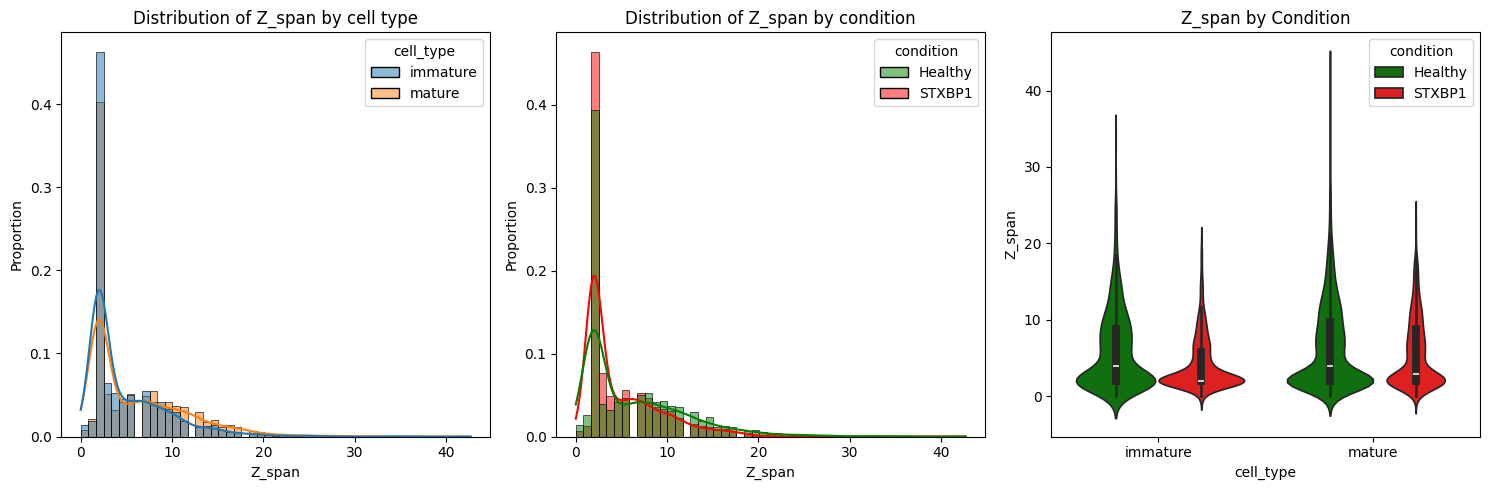

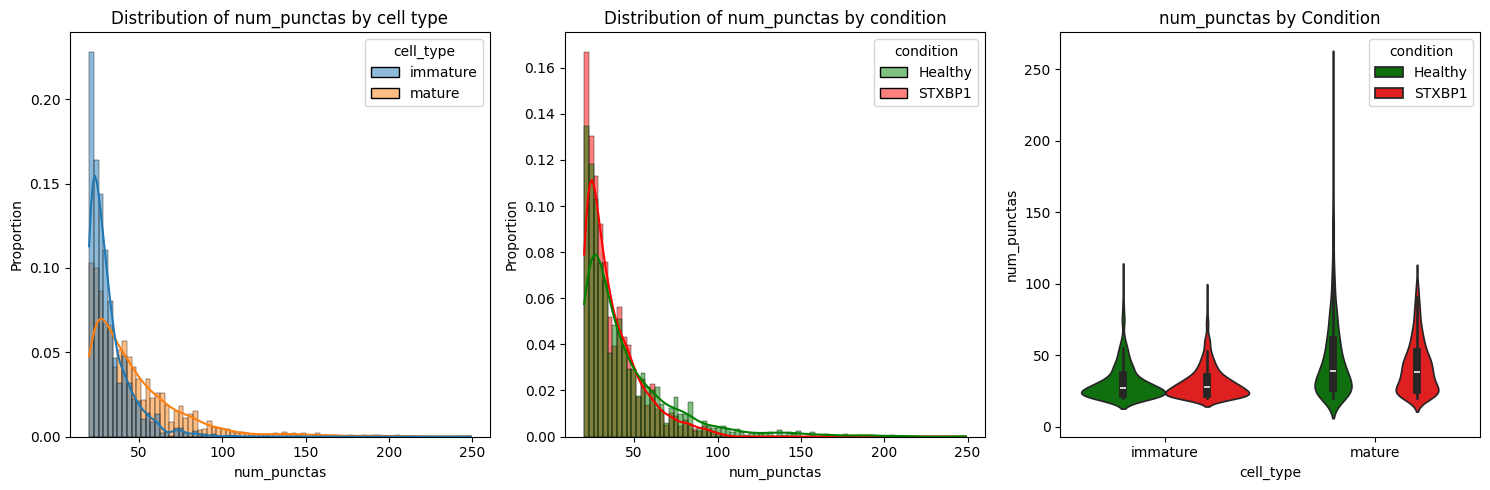

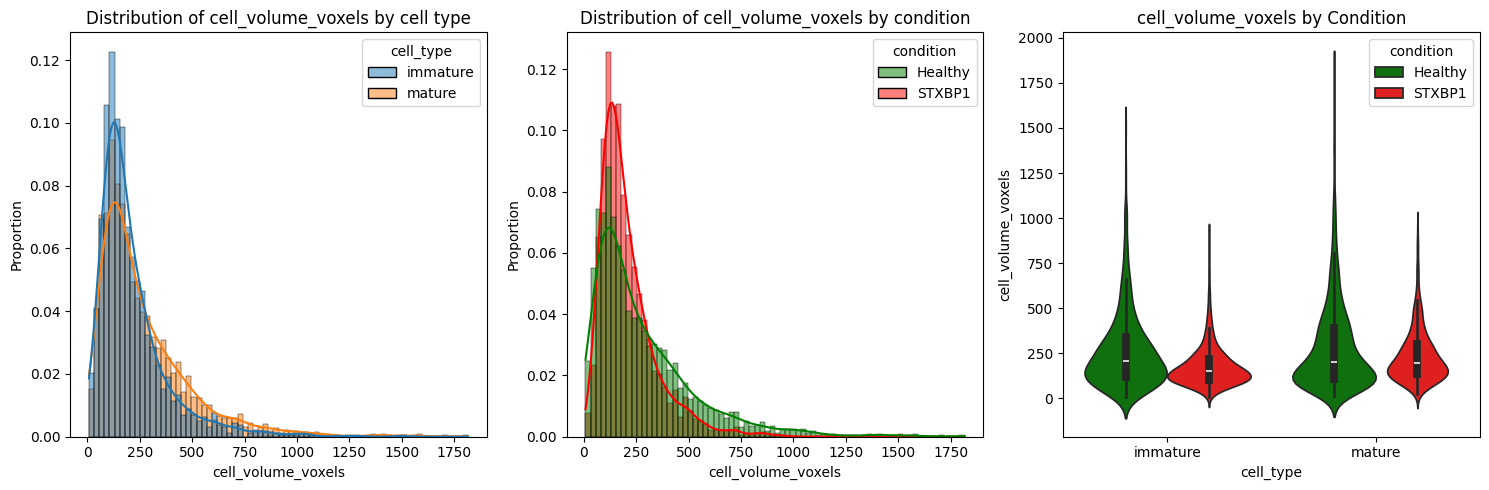

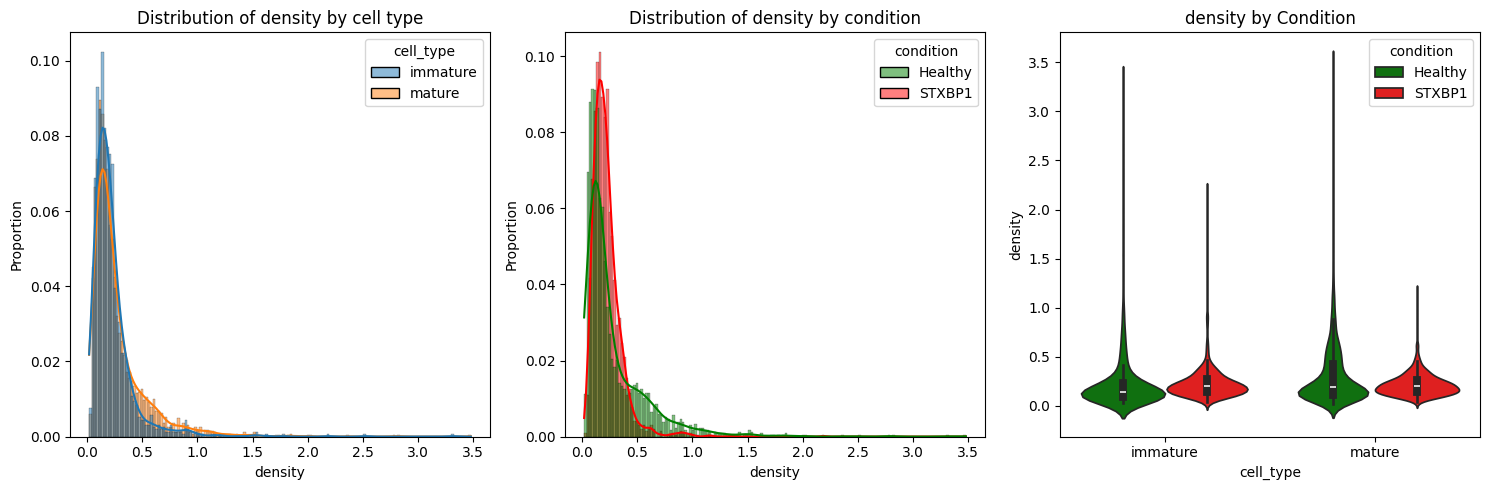

In [11]:
vis.visualize_cell_features(
    all_organoids_cells[(all_organoids_cells['num_punctas'] >= 1) & (all_organoids_cells['cell_type'] != 'type_nan')], 
    features=['Z_span', 'num_punctas', 'cell_volume_voxels', 'density'],
    save_path=figures_path
)

In [12]:
all_organoids_cells['sample'].value_counts()

sample
002CTR_D5_twins_right      4055
002CTR_D5_twins_left       2898
001STXBP1_C4_right         2623
001STXBP1_C4_left          2614
002CTR_B1_right            2311
002CTR_B1_left             2208
002CTR_D3                  2106
001STXBP1_A2_left          1687
001STXBP1_A3               1417
002CTR_B1_up               1393
001STXBP1_C3_top           1222
002CTR_D4                  1212
001STXBP1_C3_down_right    1160
001STXBP1_C3_down_left      992
001STXBP1_A2_right          729
001STXBP1_A2_up             418
Name: count, dtype: int64

In [13]:
filtered_cells = all_organoids_cells[all_organoids_cells['num_punctas'] >= 1]
print(len(filtered_cells))
filtered_cells = filtered_cells[filtered_cells['cell_type'] != 'type_nan']
print(len(filtered_cells))
filtered_cells = filtered_cells[filtered_cells['Z_span'] > 3]
print(len(filtered_cells))
filtered_cells['sample'].value_counts()

4321
4256
2079


sample
002CTR_D5_twins_left       225
002CTR_D5_twins_right      219
002CTR_B1_left             218
002CTR_D3                  171
002CTR_B1_up               141
002CTR_D4                  139
001STXBP1_C4_right         133
001STXBP1_C4_left          131
001STXBP1_C3_top           121
002CTR_B1_right            121
001STXBP1_C3_down_right    100
001STXBP1_C3_down_left      91
001STXBP1_A3                86
001STXBP1_A2_left           75
001STXBP1_A2_right          61
001STXBP1_A2_up             47
Name: count, dtype: int64

# analyze cell features

### helper function

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Optional, Dict, List, Tuple, Union

try:
    from scipy.stats import gaussian_kde
    _HAVE_SCIPY = True
except Exception:
    _HAVE_SCIPY = False

## first glance

In [15]:
filtered_cells.columns

Index(['cell_id', 'num_punctas', 'X_centroid', 'Y_centroid', 'Z_centroid',
       'cell_volume_voxels', 'voxel_centroid_x', 'voxel_centroid_y',
       'voxel_centroid_z', 'Z_span', 'convex_volume', 'convex_area', 'density',
       'compactness', 'cell_type', 'sample', 'condition'],
      dtype='object')

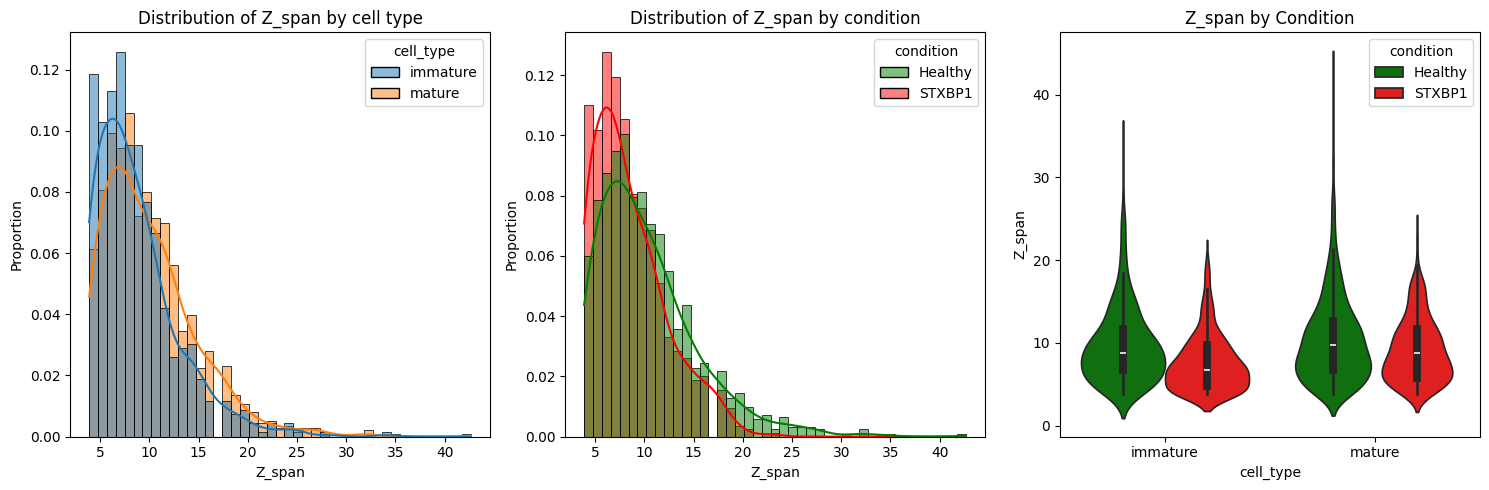

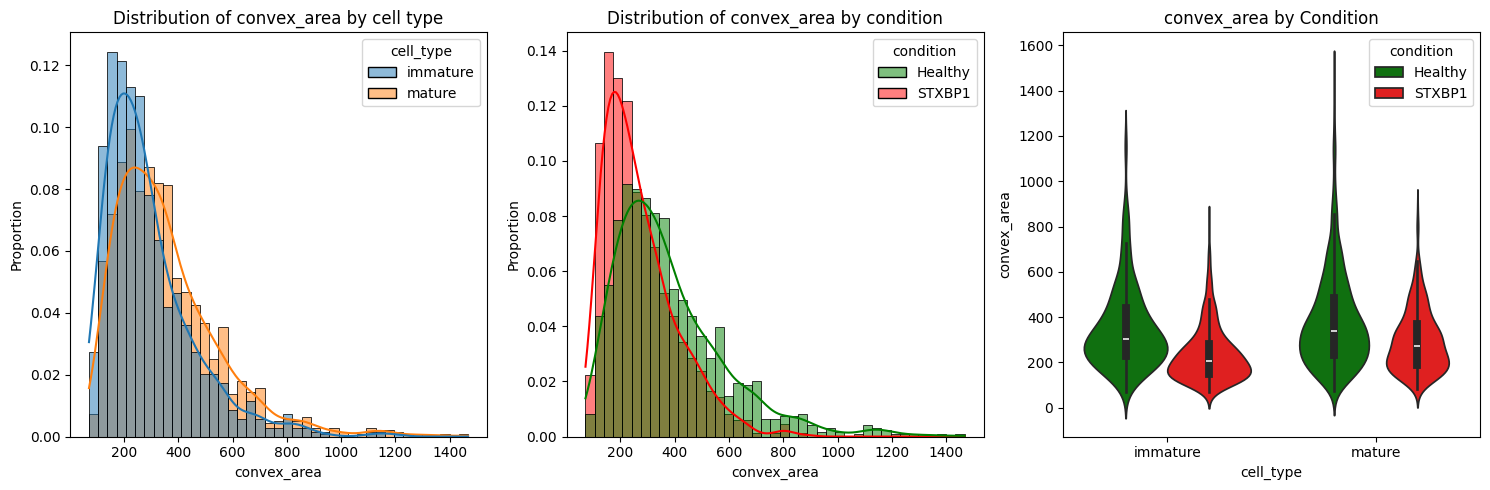

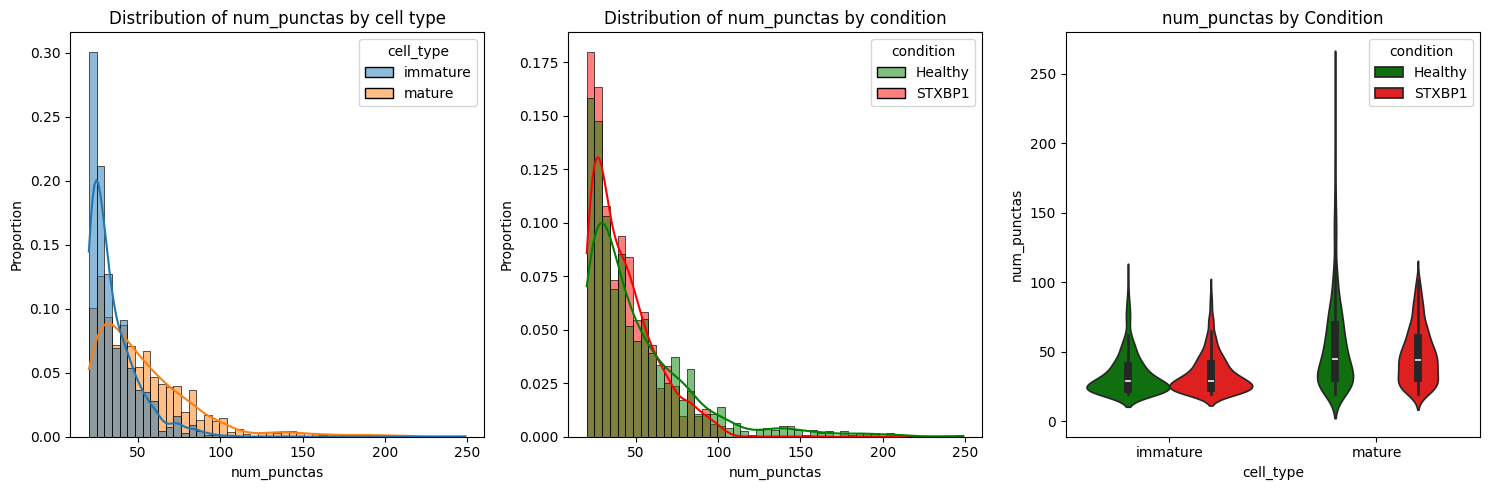

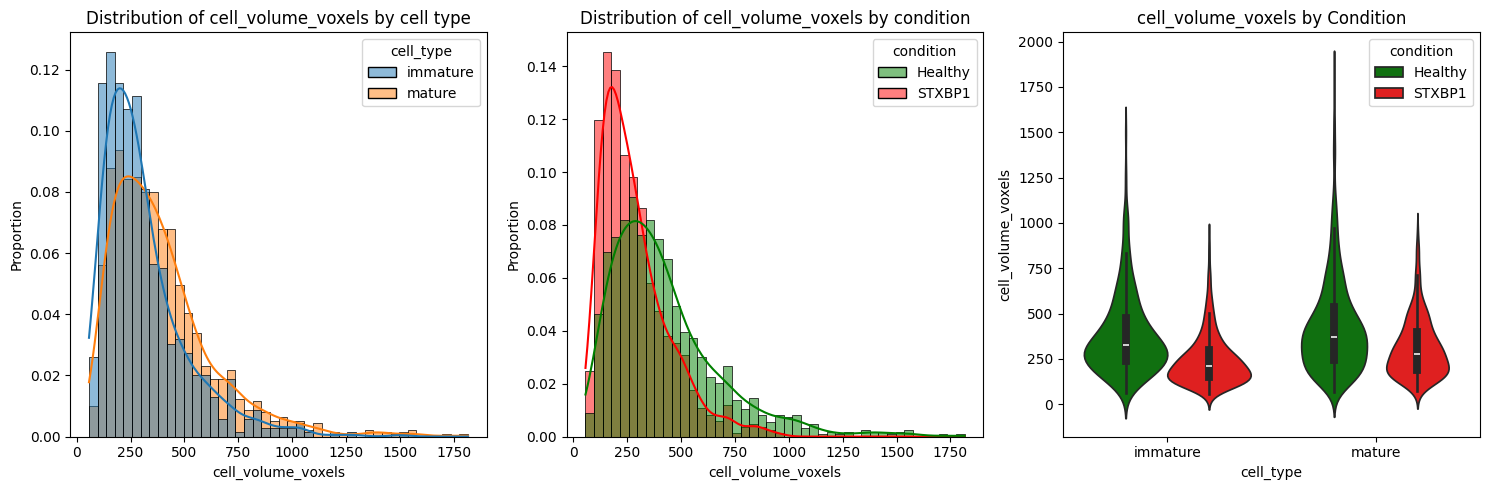

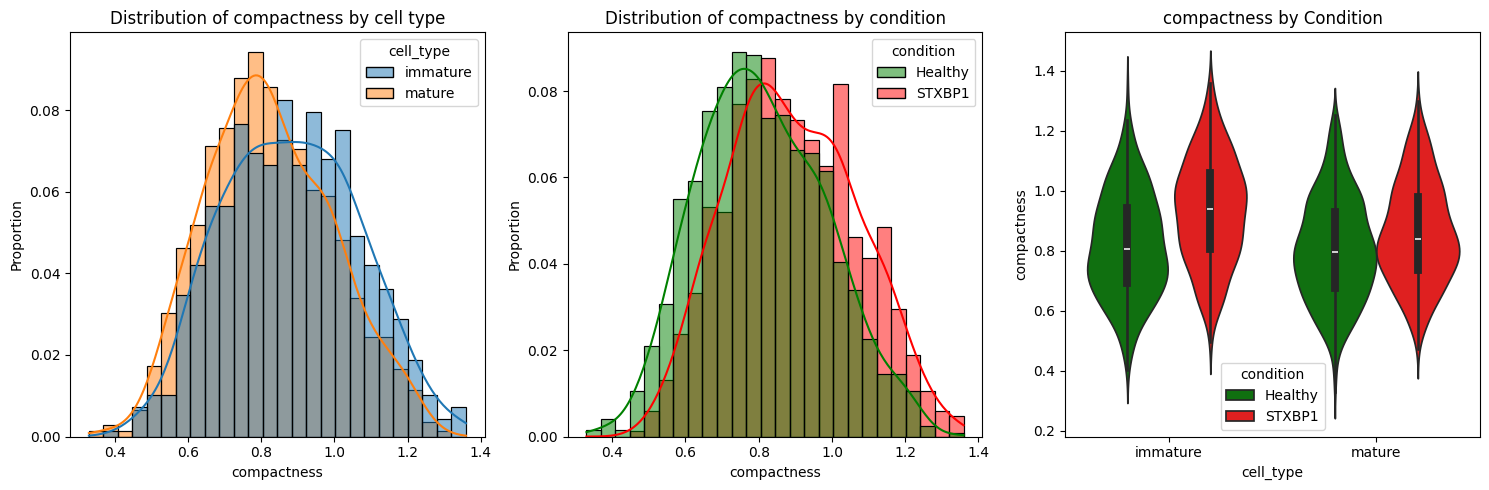

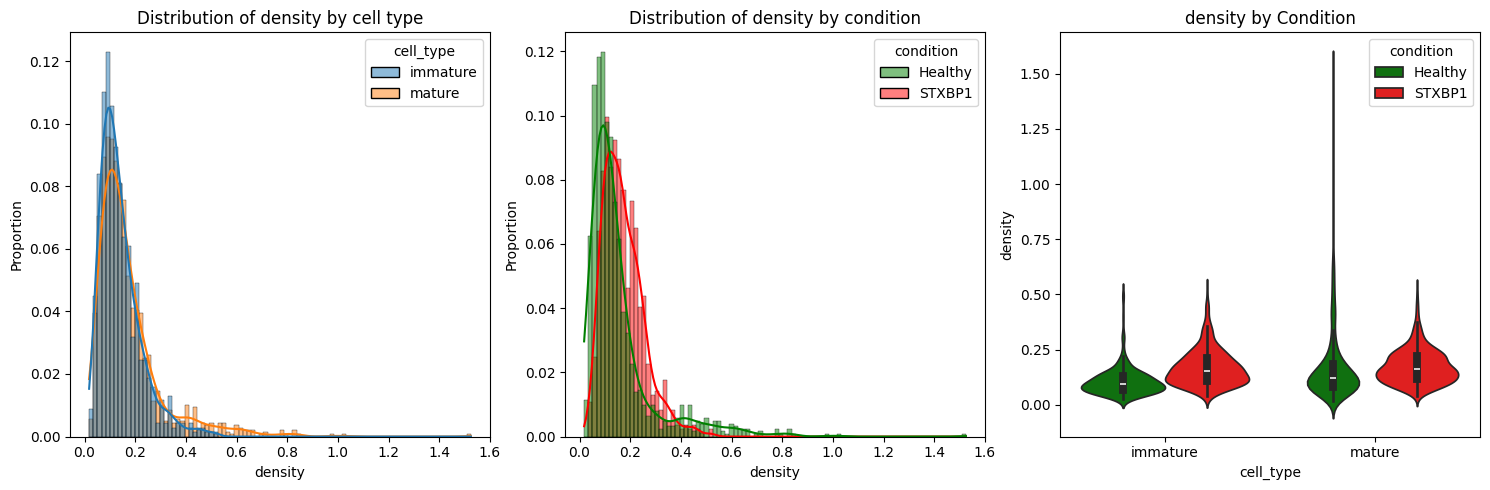

In [16]:
vis.visualize_cell_features(filtered_cells, features=['Z_span','semi_radius','convex_area', 'num_punctas', 'cell_volume_voxels', 'convex_', 'compactness', 'density'],
                           save_path=figures_path)

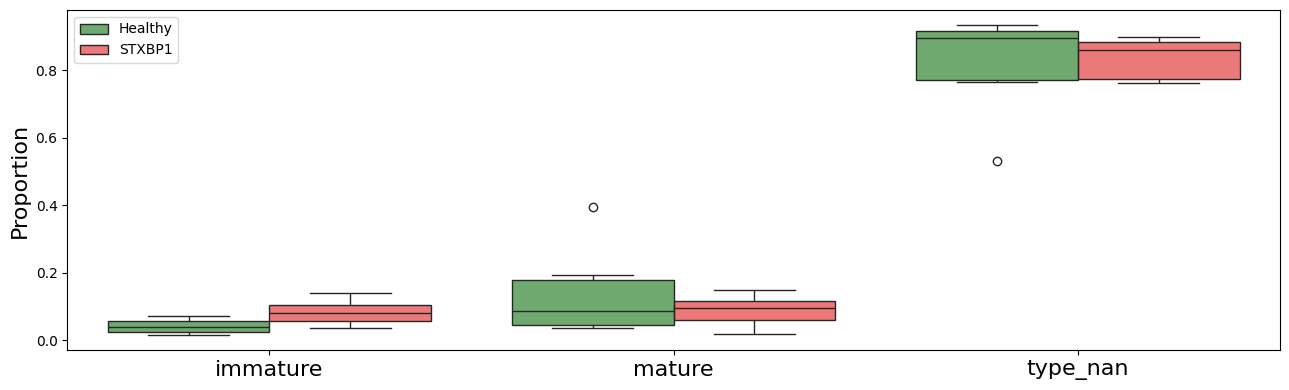

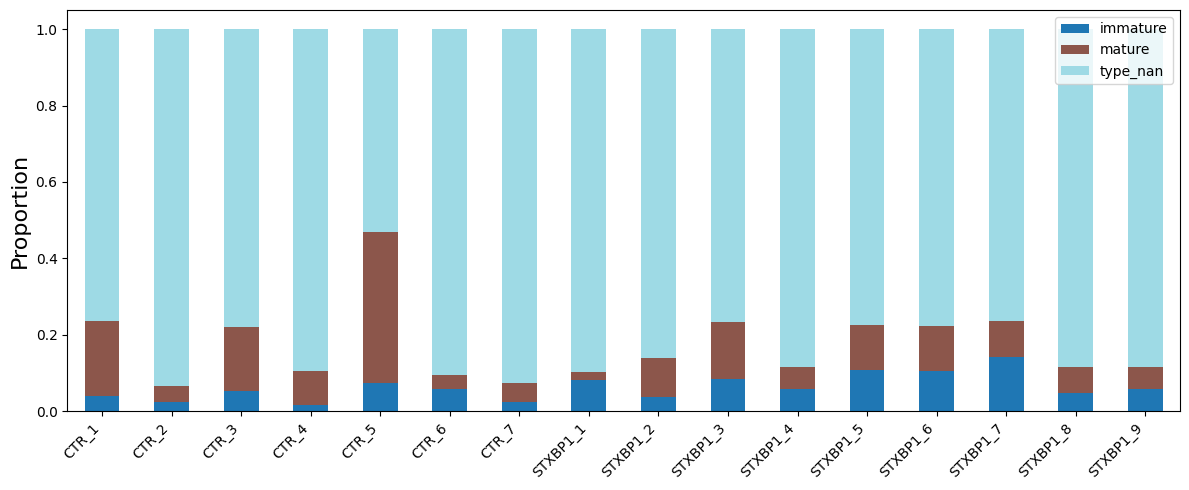

  cell_type  mannwhitney_p  perm_p  control_mean  sick_mean
0  immature       0.031119   0.019      0.041464   0.080114
1    mature       0.837063   0.295      0.139008   0.087619
2  type_nan       0.407867   0.846      0.819528   0.832266


In [17]:
label_size = 16
# Step 2: Run count types analysis
df_counts, df_stats, (fig1, fig3) = organoids_data.analyze_cell_type_population(mode='relative', n_permutations=1000, x_label_size=label_size, y_label_size=label_size, save_path=figures_path, figsize=(13,4))

# Step 3: Show the plots
plt.show()

# Step 4: Optionally display the stats
print(df_stats)


## volume, density and compactness across types and conditions

### volume (by voxels)

C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()


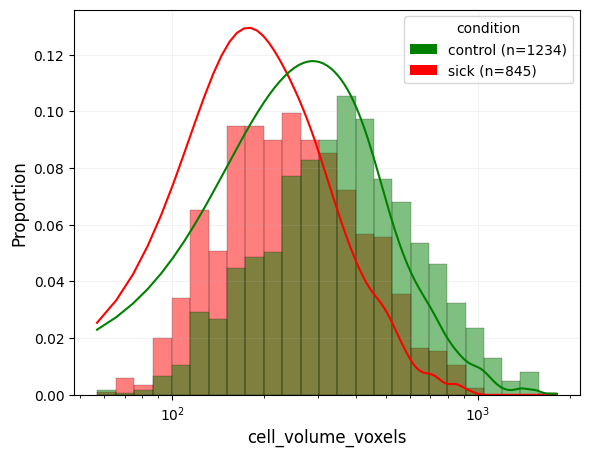

In [18]:

fig, axes = vis.plot_feature_distributions(
    df=filtered_cells,
    feature='cell_volume_voxels',
    common_norm=False,
    hue='condition',
    stat='proportion',
    palette={'control': 'green', 'sick': 'red'},
    xscale='log10',
    bins=25,
    figsize = (6,5),
    legend_count_mode='panel',
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    suptitle='',
    save_path=figures_path + '/' + 'volume_histograms'
)

C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()
C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()


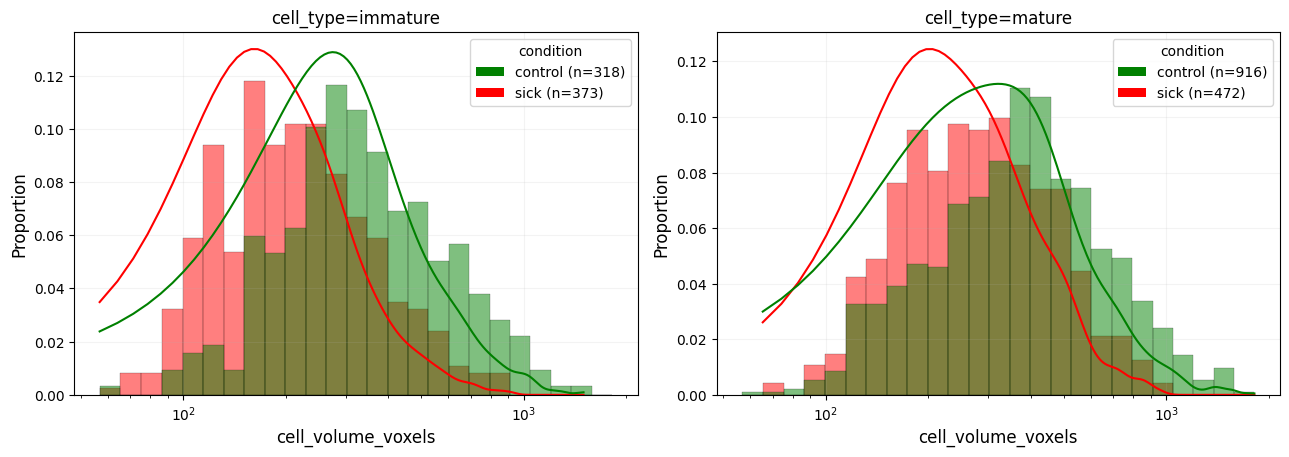

In [19]:

fig, axes = vis.plot_feature_distributions(
    df=filtered_cells,
    feature='cell_volume_voxels',
    hue='condition',
    stat='proportion',
    col_facet='cell_type',
    col_order=['immature','mature'],
    include_levels={'condition': ['control','sick'], 'cell_type': ['immature','mature']},
    hue_order=['control','sick'],
    palette={'control': 'green', 'sick': 'red'},
    xscale='log10',
    bins=25,
    figsize = (13,5),
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    suptitle='',
    legend_count_mode='panel',
    save_path=figures_path + '/' + 'volume_histograms_2_types'

)

C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()
C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()


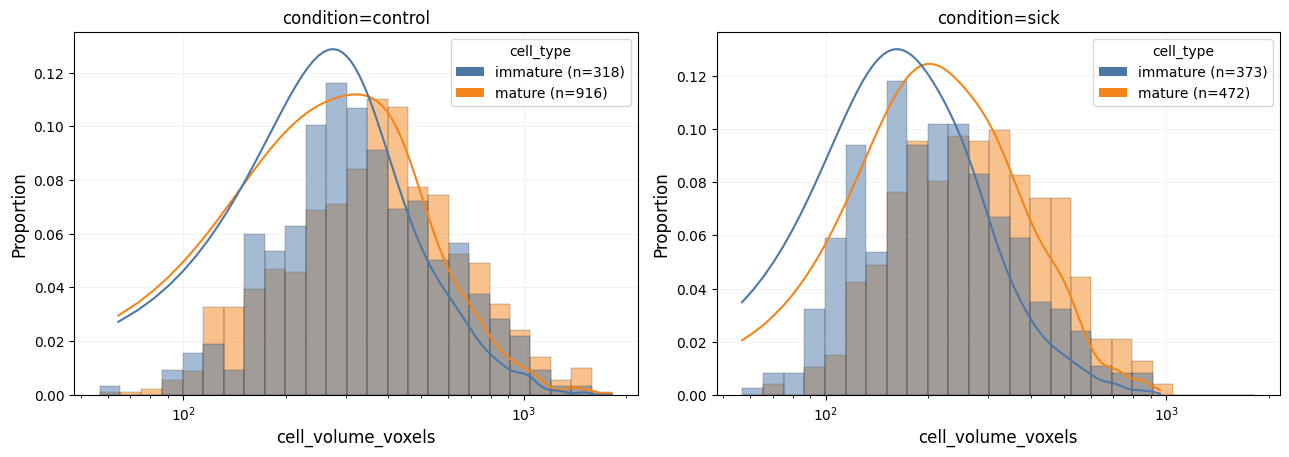

In [20]:

fig, axes = vis.plot_feature_distributions(
    df=filtered_cells,
    feature='cell_volume_voxels',
    hue='cell_type',
    stat='proportion',
    col_facet='condition',
    include_levels={'condition': ['control','sick'], 'cell_type': ['immature','mature']},
    hue_order=['immature','mature'],
    palette={'immature': '#4C78A8', 'mature': '#F58518'},    
    xscale='log10',
    bins=25,
    figsize = (13,5),
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    suptitle='',
    legend_count_mode='panel',
    save_path=figures_path + '/' + 'volume_histograms_2_conditions'

)

### num_punctas

C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()


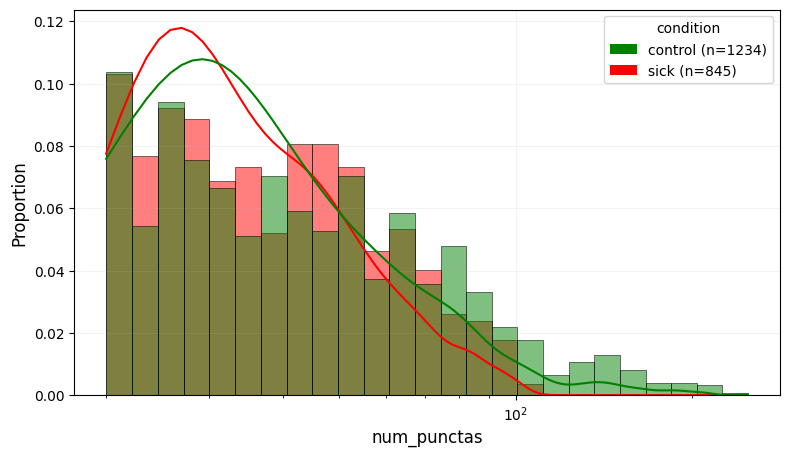

In [21]:

fig, axes = vis.plot_feature_distributions(
    df=filtered_cells,
    feature='num_punctas',
    hue='condition',
    stat='proportion',
    # col_facet='cell_type',
    # include_levels={'condition': ['control','sick'], 'cell_type': ['immature','mature']},
    hue_order=['control','sick'],
    palette={'control': 'green', 'sick': 'red'},
    bins=25,
    xscale='log10',
    clip_percentiles=(0, 100.0),
    figsize = (8,5),
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    suptitle='',
    legend_count_mode='panel',
    save_path=figures_path + '/' + 'expression_histograms'

)

### density

C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()


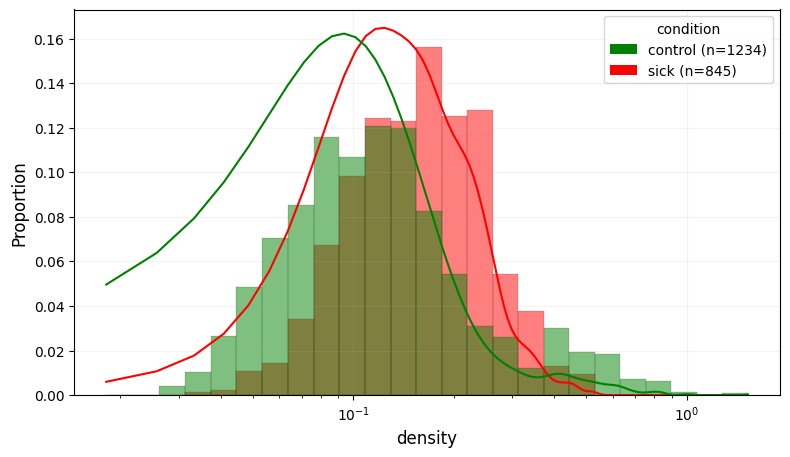

In [22]:

fig, axes = vis.plot_feature_distributions(
    df=filtered_cells,
    feature='density',
    hue='condition',
    stat='proportion',
    # col_facet='cell_type',
    # include_levels={'condition': ['control','sick'], 'cell_type': ['immature','mature']},
    hue_order=['control','sick'],
    palette={'control': 'green', 'sick': 'red'},
    bins=25,
    clip_percentiles=(0, 100.0),
    xscale='log10',
    figsize = (8,5),
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    suptitle='',
    save_path=figures_path + '/' + 'density_histograms',
    legend_count_mode='panel',
)

### compactness

C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()
C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()


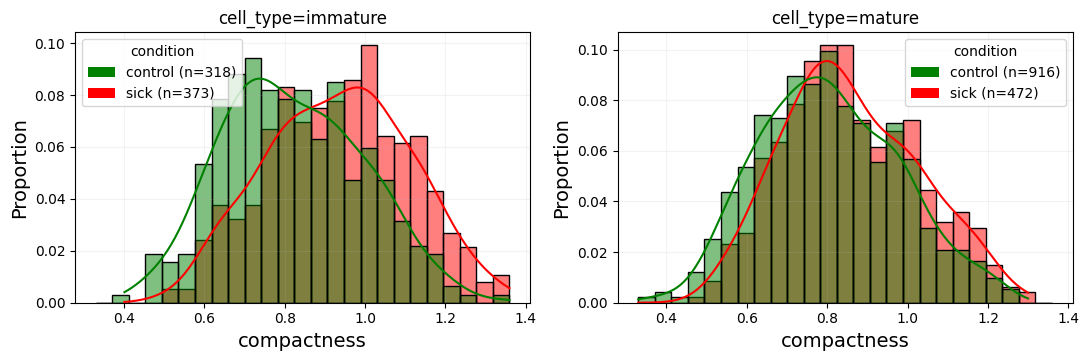

In [23]:

fig, axes = vis.plot_feature_distributions(
    df=filtered_cells,
    feature='compactness',
    hue='condition',
    stat='proportion',
    col_facet='cell_type',
    col_order=['immature','mature'],
    include_levels={'condition': ['control','sick'], 'cell_type': ['immature','mature']},
    hue_order=['control','sick'],
    palette={'control': 'green', 'sick': 'red'},
    bins=25,
    figsize = (11,4),
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    suptitle='',
    save_path=figures_path + '/' + 'compactness_histograms_2_types',
    legend_count_mode='panel'    
)

C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()
C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()


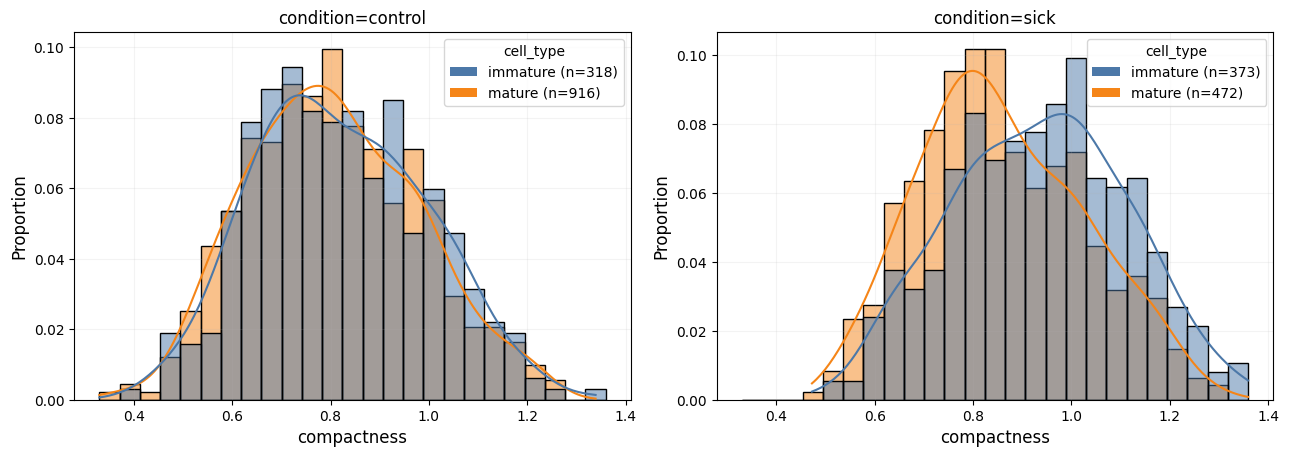

In [24]:

fig, axes = vis.plot_feature_distributions(
    df=filtered_cells,
    feature='compactness',
    hue='cell_type',
    stat='proportion',
    col_facet='condition',
    include_levels={'condition': ['control','sick'], 'cell_type': ['immature','mature']},
    hue_order=['immature','mature'],
    palette={'immature': '#4C78A8', 'mature': '#F58518'},    
    bins=25,
    figsize = (13,5),
    xlabel_fontsize=12,
    ylabel_fontsize=12,
    suptitle='',
    save_path=figures_path + '/' + 'compactness_histograms_2_conditions',
    legend_count_mode='panel'    
)

### STXBP1 expression (not significant)

In [25]:

filtered_cells['STXBP1 expression'] = 0
for index, row in filtered_cells.iterrows():
    matrix = organoids_data.samples[row['sample']].gene_cell_matrix
    exp = matrix.loc['STXBP1', row['cell_id']]
    filtered_cells.loc[index, 'STXBP1 expression'] = exp


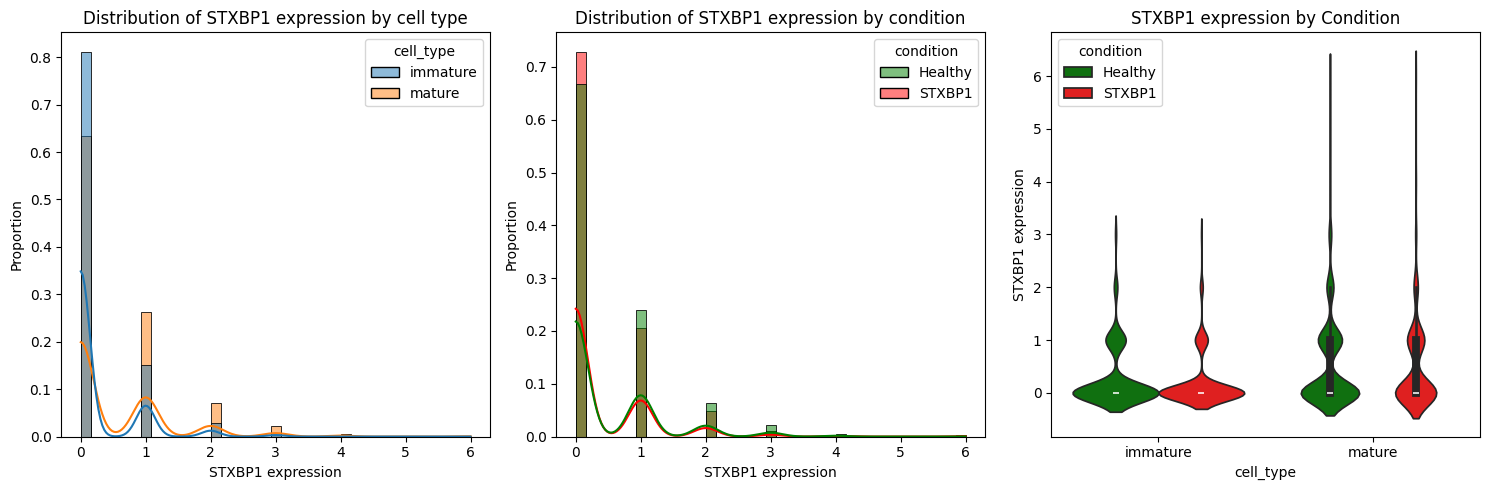

In [26]:
vis.visualize_cell_features(filtered_cells, ['STXBP1 expression'])

C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()
C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()


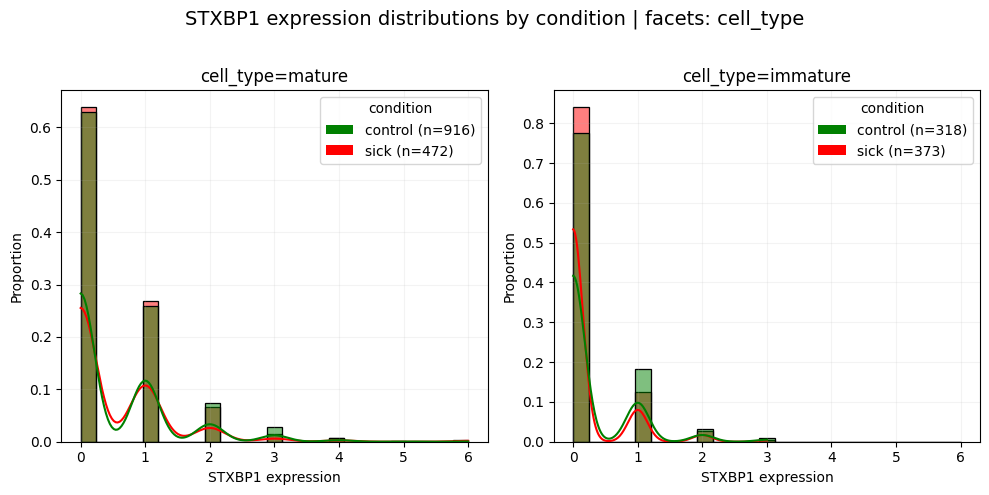

In [27]:

fig, axes = vis.plot_feature_distributions(
    df=filtered_cells,
    feature='STXBP1 expression',
    hue='condition',
    col_facet='cell_type',
    palette={'control': 'green', 'sick': 'red'},  
    bins=25,
    clip_percentiles=(0, 100.0),
    legend_count_mode='panel'    
)

C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()
C:\mnt/data\exseq_kit\visualization\stat_vis_df.py:471: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_counts = panel_df.groupby(hue).size().reindex(hue_order, fill_value=0).to_dict()


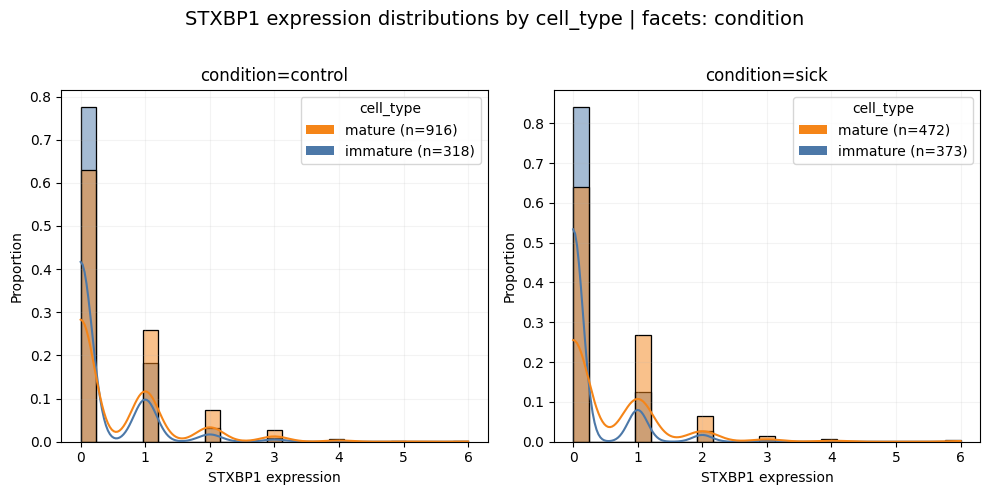

In [28]:

fig, axes = vis.plot_feature_distributions(
    df=filtered_cells,
    feature='STXBP1 expression',
    hue='cell_type',
    col_facet='condition',
    palette={'immature': '#4C78A8', 'mature': '#F58518'},    
    bins=25,
    clip_percentiles=(0, 100.0),
    legend_count_mode='panel'    
)

## Feature correlations and influence testing 

### Compactness & num of puncta

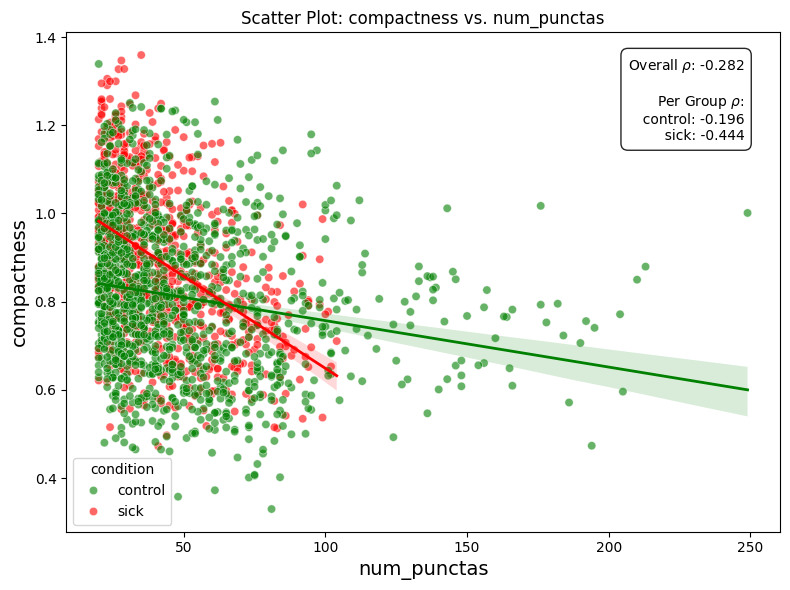

In [29]:
vis.plot_correlation_scatter(
    df=filtered_cells,
    feature_x='num_punctas',
    feature_y='compactness',
    hue='condition',
    palette=custom_palette,
    save_path=figures_path,
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    figsize=(8,6)
    
)

facet    group  bin_idx  x_left  x_right  x_center    n     y_mean  \
0   None  control        0   0.329    0.458    0.3935   11  70.909091   
1   None  control        1   0.458    0.587    0.5225  110  57.800000   
2   None  control        2   0.587    0.716    0.6515  263  56.079848   
3   None  control        3   0.716    0.845    0.7805  346  51.419075   
4   None  control        4   0.845    0.973    0.9090  271  44.819188   
5   None  control        5   0.973    1.102    1.0375  166  43.295181   
6   None  control        6   1.102    1.231    1.1665   58  40.310345   
7   None  control        7   1.231    1.359    1.2950    9  39.555556   
8   None     sick        0   0.329    0.458    0.3935    0        NaN   
9   None     sick        1   0.458    0.587    0.5225   24  56.000000   
10  None     sick        2   0.587    0.716    0.6515  119  54.579832   
11  None     sick        3   0.716    0.845    0.7805  220  47.918182   
12  None     sick        4   0.845    0.973    0.9090  200  38.045000   
13  None     sick        5   0.973    1.102    1.0375  166  34.469880   
14  None     sick        6   1.102    1.231    1.1665   95  31.957895   
15  None     sick        7   1.231    1.359    1.2950   21  27.095238   

     y_variance      y_agg  y_spread_low  y_spread_high  
0    113.290909  70.909091     67.699858      74.118323  
1    830.234862  57.800000     55.052712      60.547288  
2   1070.096653  56.079848     54.062719      58.096977  
3   1346.568795  51.419075     49.446306      53.391844  
4    822.230149  44.819188     43.077333      46.561043  
5    918.948704  43.295181     40.942345      45.648016  
6    447.094979  40.310345     37.533920      43.086770  
7    137.777778  39.555556     35.642930      43.468182  
8           NaN        NaN           NaN            NaN  
9    480.000000  56.000000     51.527864      60.472136  
10   414.974505  54.579832     52.712432      56.447231  
11   389.874554  47.918182     46.586958      49.249406  
12   227.902487  38.045000     36.977521      39.112479  
13   211.729390  34.469880     33.340509      35.599250  
14   102.402464  31.957895     30.919665      32.996124  
15    39.990476  27.095238     25.715271      28.475205

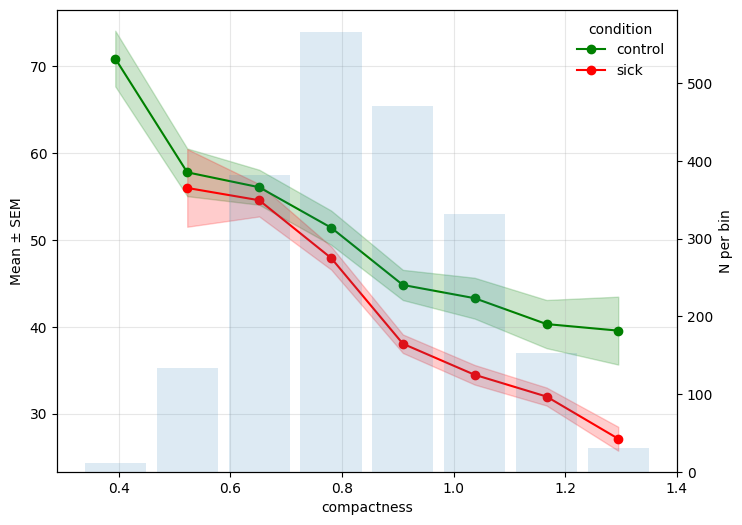

In [62]:
reload(vis_module)

compactness_fig, ax, compactness_summary_df = vis.binned_summary_plot(df=filtered_cells, x="compactness", y="num_punctas",
                                          group="condition", 
                                          bins="uniform", n_bins=8, share_bins=True, colors=custom_palette,
                                          agg="mean", spread="sem")
compactness_summary_df

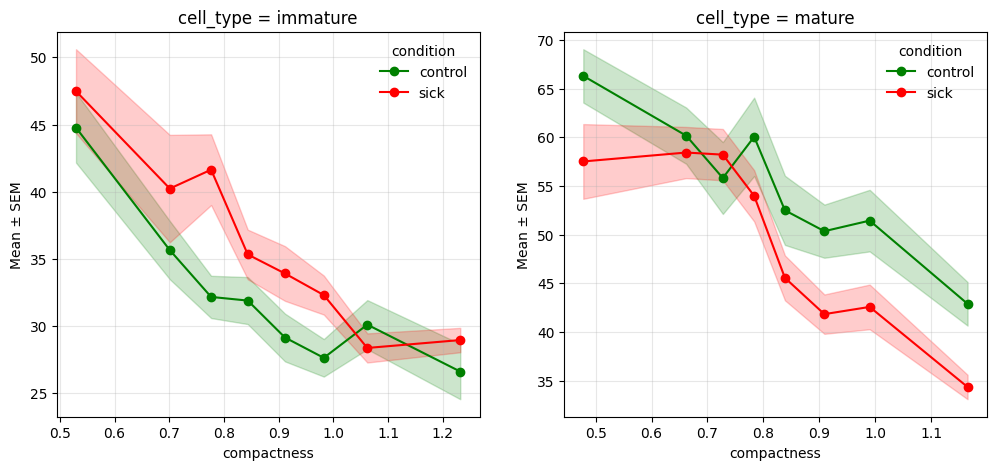

In [31]:
reload(vis_module)

fig, ax, summary_df = vis.binned_summary_plot(df=filtered_cells, x="compactness", y="num_punctas",
                                          group="condition", facet="cell_type",
                                          bins="quantile", n_bins=8, share_bins=True, colors=custom_palette,
                                          agg="mean", spread="sem", figsize=(12,5), show_counts=False)


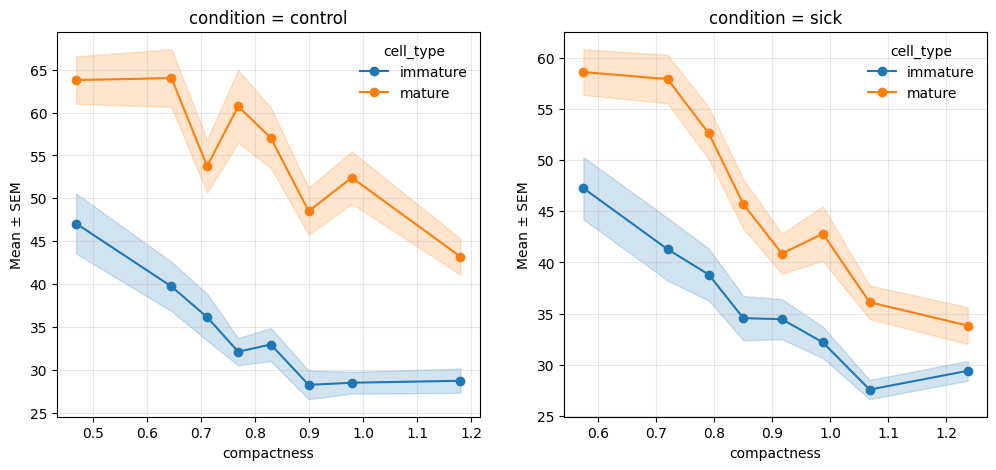

In [32]:
reload(vis_module)

fig, ax, summary_df = vis.binned_summary_plot(df=filtered_cells, x="compactness", y="num_punctas",
                                          group="cell_type", facet="condition",
                                          bins="quantile", n_bins=8, share_bins=True, 
                                          agg="mean", spread="sem", figsize=(12,5), show_counts=False)


### Volumes & num of puncta

#### volume & volume

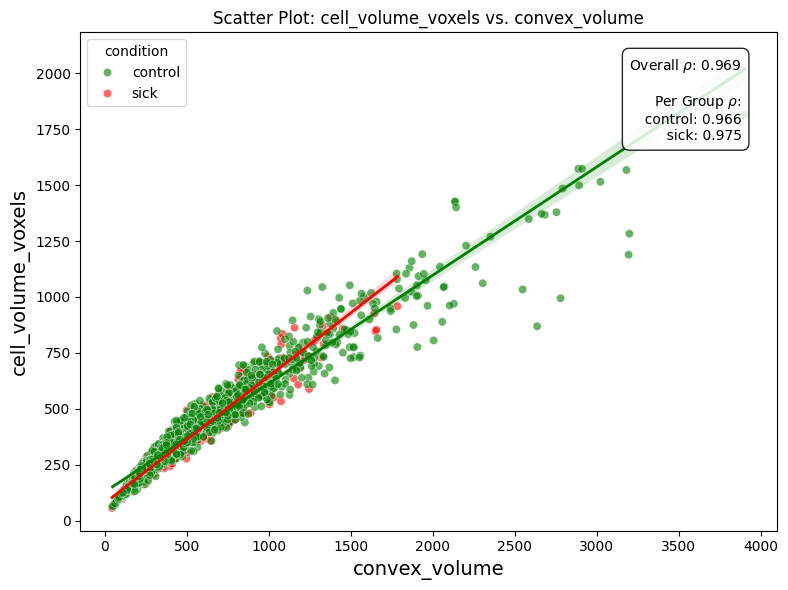

In [33]:
vis.plot_correlation_scatter(
    df=filtered_cells,
    feature_x='convex_volume',
    feature_y='cell_volume_voxels',
    hue='condition',
    palette=custom_palette,
    save_path=figures_path,
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    figsize=(8,6)
    
)

facet    group  bin_idx    x_left   x_right   x_center    n       y_mean  \
0   None  control        0    56.823   276.665   166.7440  403   210.565954   
1   None  control        1   276.665   496.505   386.5850  488   483.222390   
2   None  control        2   496.505   716.346   606.4255  202   893.231703   
3   None  control        3   716.346   936.186   826.2660   81  1355.587249   
4   None  control        4   936.186  1156.026  1046.1060   39  1825.803603   
5   None  control        5  1156.026  1375.867  1265.9465    9  2521.189331   
6   None  control        6  1375.867  1595.707  1485.7870   10  2685.724220   
7   None  control        7  1595.707  1815.547  1705.6270    2          NaN   
8   None     sick        0    56.823   276.665   166.7440  498   191.485961   
9   None     sick        1   276.665   496.505   386.5850  261   482.180655   
10  None     sick        2   496.505   716.346   606.4255   66   855.791559   
11  None     sick        3   716.346   936.186   826.2660   19  1281.887284   
12  None     sick        4   936.186  1156.026  1046.1060    1          NaN   
13  None     sick        5  1156.026  1375.867  1265.9465    0          NaN   
14  None     sick        6  1375.867  1595.707  1485.7870    0          NaN   
15  None     sick        7  1595.707  1815.547  1705.6270    0          NaN   

       y_variance        y_agg  y_spread_low  y_spread_high  
0     5474.218031   210.565954    206.880351     214.251556  
1    15371.030344   483.222390    477.610080     488.834699  
2    29776.166252   893.231703    881.090584     905.372822  
3    68912.555690  1355.587249   1326.419248    1384.755250  
4   102117.411461  1825.803603   1774.633347    1876.973860  
5   232029.881591  2521.189331   2360.624398    2681.754265  
6   156381.585947  2685.724220   2560.671596    2810.776843  
7             NaN          NaN           NaN            NaN  
8     5687.735209   191.485961    188.106441     194.865481  
9    16841.751152   482.180655    474.147736     490.213574  
10   21470.008110   855.791559    837.755397     873.827722  
11   40873.414088  1281.887284   1235.505905    1328.268663  
12            NaN          NaN           NaN            NaN  
13            NaN          NaN           NaN            NaN  
14            NaN          NaN           NaN            NaN  
15            NaN          NaN           NaN            NaN

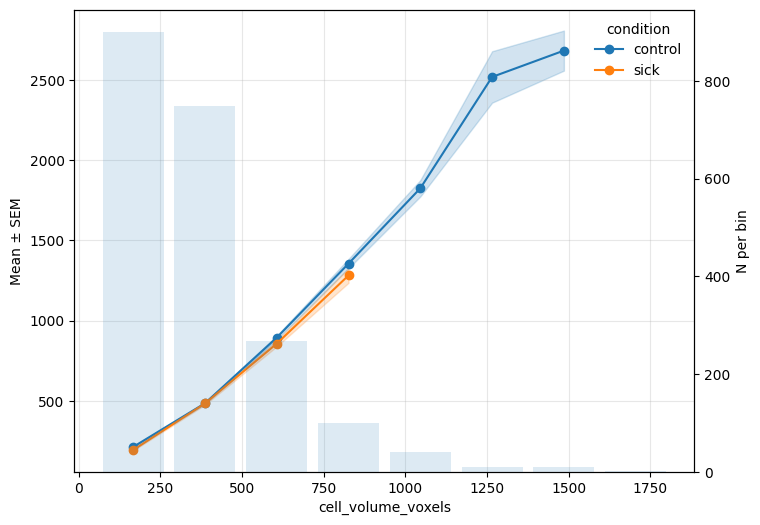

In [34]:
reload(vis_module)

fig, ax, summary_df = vis.binned_summary_plot(df=filtered_cells, x="cell_volume_voxels", y="convex_volume",
                                          group="condition",
                                          bins="uniform", n_bins=8, share_bins=True,
                                          agg="mean", spread="sem")
summary_df

#### convex volume & n puncta

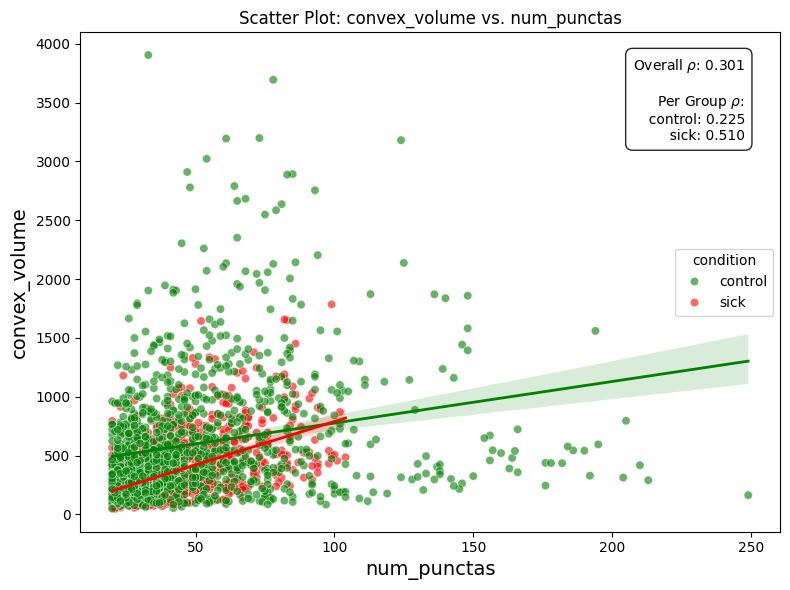

In [35]:
vis.plot_correlation_scatter(
    df=filtered_cells,
    feature_x='num_punctas',
    feature_y='convex_volume',
    hue='condition',
    palette=custom_palette,
    save_path=figures_path,
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    figsize=(8,6)
    
)

facet    group  bin_idx    x_left   x_right   x_center    n     y_mean  \
0   None  control        0    45.131   134.257    89.6940   74  42.527027   
1   None  control        1   134.257   187.876   161.0665   79  46.506329   
2   None  control        2   187.876   242.512   215.1940  110  39.027273   
3   None  control        3   242.512   301.347   271.9295  104  44.336538   
4   None  control        4   301.347   364.387   332.8670  126  44.785714   
5   None  control        5   364.387   450.401   407.3940  131  50.587786   
6   None  control        6   450.401   551.163   500.7820  145  49.834483   
7   None  control        7   551.163   729.091   640.1270  140  50.692857   
8   None  control        8   729.091  1018.201   873.6460  146  50.500000   
9   None  control        9  1018.201  3904.913  2461.5570  179  67.117318   
10  None     sick        0    45.131   134.257    89.6940  134  29.477612   
11  None     sick        1   134.257   187.876   161.0665  129  32.224806   
12  None     sick        2   187.876   242.512   215.1940   98  38.622449   
13  None     sick        3   242.512   301.347   271.9295  104  39.326923   
14  None     sick        4   301.347   364.387   332.8670   82  41.926829   
15  None     sick        5   364.387   450.401   407.3940   76  47.605263   
16  None     sick        6   450.401   551.163   500.7820   63  53.920635   
17  None     sick        7   551.163   729.091   640.1270   68  50.602941   
18  None     sick        8   729.091  1018.201   873.6460   62  57.354839   
19  None     sick        9  1018.201  3904.913  2461.5570   29  65.000000   

     y_variance      y_agg  y_spread_low  y_spread_high  
0    467.622547  42.527027     40.013220      45.040834  
1   1263.355729  46.506329     42.507349      50.505310  
2    663.843286  39.027273     36.570661      41.483884  
3   1135.642924  44.336538     41.032050      47.641027  
4   1188.105714  44.785714     41.714980      47.856449  
5   1290.613388  50.587786     47.448995      53.726578  
6   1106.319636  49.834483     47.072275      52.596690  
7   1066.012898  50.692857     47.933441      53.452273  
8    645.231034  50.500000     48.397765      52.602235  
9    914.665934  67.117318     64.856817      69.377820  
10    89.439345  29.477612     28.660631      30.294593  
11   100.535005  32.224806     31.342003      33.107609  
12   246.876604  38.622449     37.035266      40.209632  
13   182.688200  39.326923     38.001549      40.652297  
14   303.624210  41.926829     40.002580      43.851078  
15   474.108772  47.605263     45.107610      50.102917  
16   564.041987  53.920635     50.928471      56.912799  
17   250.213126  50.602941     48.684712      52.521171  
18   388.396616  57.354839     54.851948      59.857729  
19   339.000000  65.000000     61.580986      68.419014

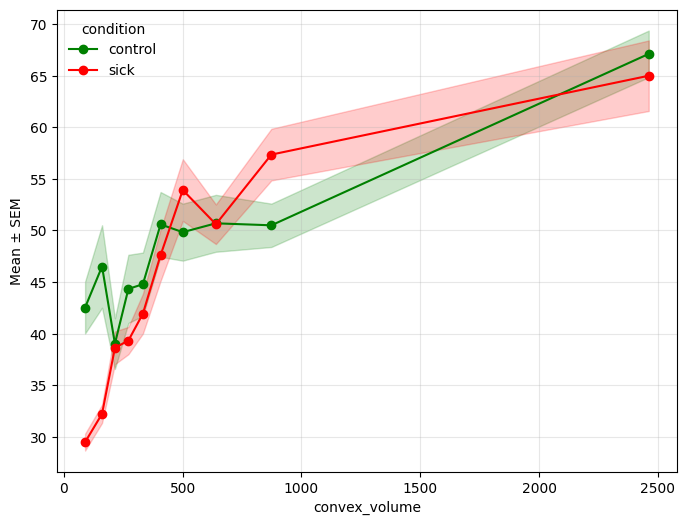

In [36]:
reload(vis_module)

fig, ax, summary_df = vis.binned_summary_plot(df=filtered_cells, x="convex_volume", y="num_punctas",
                                          group="condition",
                                          bins="quantile", n_bins=10, share_bins=True, colors=custom_palette,
                                          agg="mean", spread="sem", show_counts=False)
summary_df

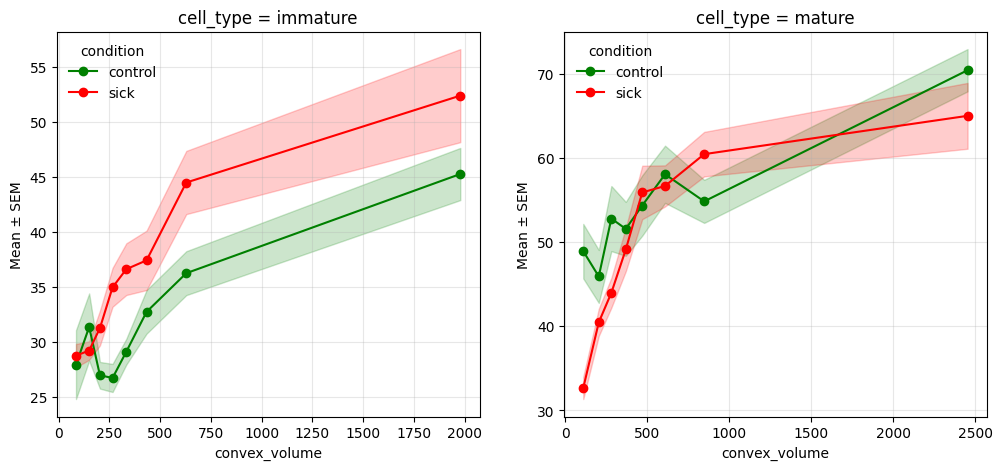

In [37]:

fig, ax, summary_df = vis.binned_summary_plot(df=filtered_cells, x="convex_volume", y="num_punctas",
                                          group="condition", facet="cell_type",
                                          bins="quantile", n_bins=8, share_bins=True, colors=custom_palette,
                                          agg="mean", spread="sem", figsize=(12,5), show_counts=False)


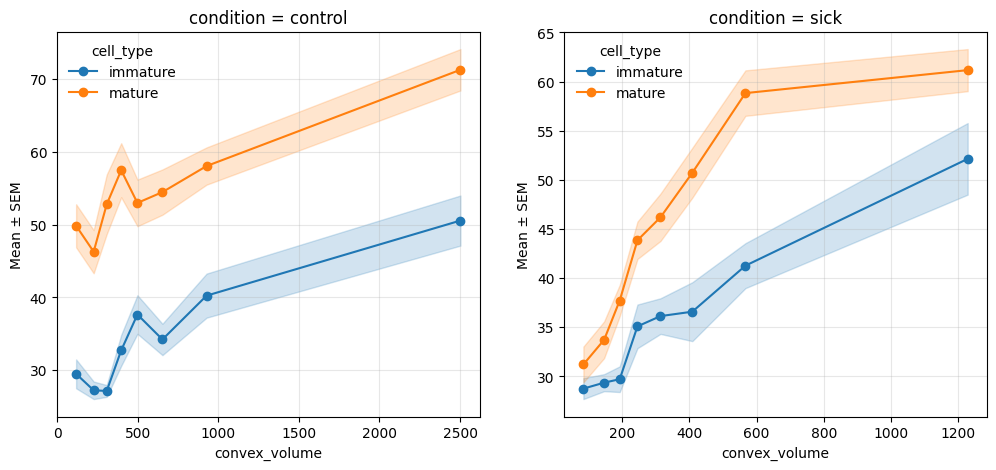

In [38]:

fig, ax, summary_df = vis.binned_summary_plot(df=filtered_cells, x="convex_volume", y="num_punctas",
                                          group="cell_type", facet="condition",
                                          bins="quantile", n_bins=8, share_bins=True, 
                                          agg="mean", spread="sem", figsize=(12,5), show_counts=False)


#### pixel volume & n puncta

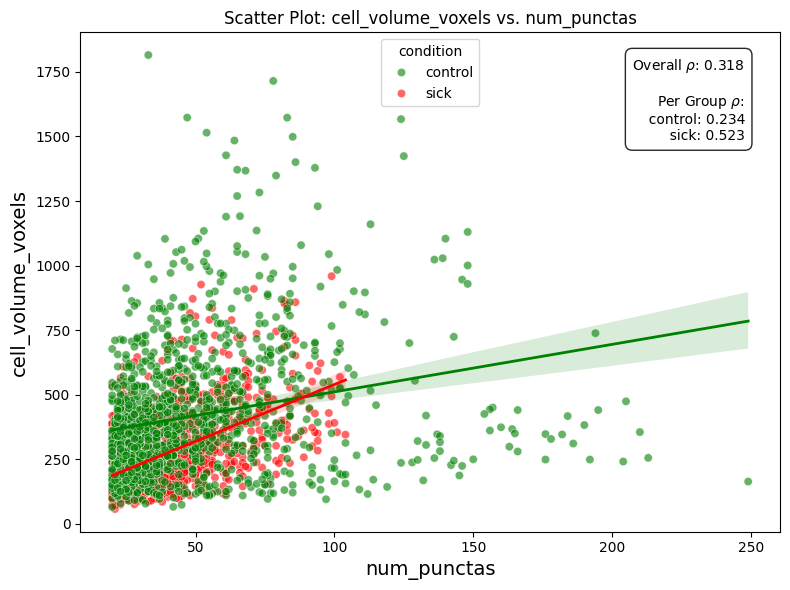

In [39]:
vis.plot_correlation_scatter(
    df=filtered_cells,
    feature_x='num_punctas',
    feature_y='cell_volume_voxels',
    hue='condition',
    palette=custom_palette,
    save_path=figures_path,
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    figsize=(8,6)
    
)

facet    group  bin_idx   x_left   x_right   x_center    n     y_mean  \
0   None  control        0   56.823   141.444    99.1335   79  42.518987   
1   None  control        1  141.444   179.172   160.3080   80  46.137500   
2   None  control        2  179.172   221.298   200.2350   97  39.288660   
3   None  control        3  221.298   262.325   241.8115  106  48.075472   
4   None  control        4  262.325   306.118   284.2215  120  44.283333   
5   None  control        5  306.118   359.043   332.5805  128  48.539062   
6   None  control        6  359.043   420.467   389.7550  146  47.054795   
7   None  control        7  420.467   501.088   460.7775  145  50.393103   
8   None  control        8  501.088   661.962   581.5250  154  53.077922   
9   None  control        9  661.962  1815.547  1238.7545  179  66.312849   
10  None     sick        0   56.823   141.444    99.1335  129  29.031008   
11  None     sick        1  141.444   179.172   160.3080  128  32.078125   
12  None     sick        2  179.172   221.298   200.2350  112  37.339286   
13  None     sick        3  221.298   262.325   241.8115  101  40.940594   
14  None     sick        4  262.325   306.118   284.2215   88  43.897727   
15  None     sick        5  306.118   359.043   332.5805   79  47.202532   
16  None     sick        6  359.043   420.467   389.7550   62  49.629032   
17  None     sick        7  420.467   501.088   460.7775   64  55.593750   
18  None     sick        8  501.088   661.962   581.5250   53  57.320755   
19  None     sick        9  661.962  1815.547  1238.7545   29  64.965517   

     y_variance      y_agg  y_spread_low  y_spread_high  
0    498.765660  42.518987     40.006322      45.031653  
1   1299.689715  46.137500     42.106852      50.168148  
2    617.769974  39.288660     36.765019      41.812301  
3   1815.060916  48.075472     43.937451      52.213493  
4    771.381232  44.283333     41.747948      46.818718  
5   1477.384289  48.539062     45.141701      51.936424  
6    927.445253  47.054795     44.534405      49.575184  
7   1049.615230  50.393103     47.702615      53.083591  
8    542.869705  53.077922     51.200390      54.955454  
9    947.047643  66.312849     64.012682      68.613016  
10    79.561531  29.031008     28.245670      29.816346  
11   117.379675  32.078125     31.120509      33.035741  
12   170.856821  37.339286     36.104171      38.574400  
13   263.236436  40.940594     39.326190      42.554998  
14   310.115857  43.897727     42.020484      45.774971  
15   456.009737  47.202532     44.799976      49.605088  
16   445.778160  49.629032     46.947620      52.310444  
17   321.832341  55.593750     53.351289      57.836211  
18   449.645138  57.320755     54.408046      60.233463  
19   281.534483  64.965517     61.849737      68.081297

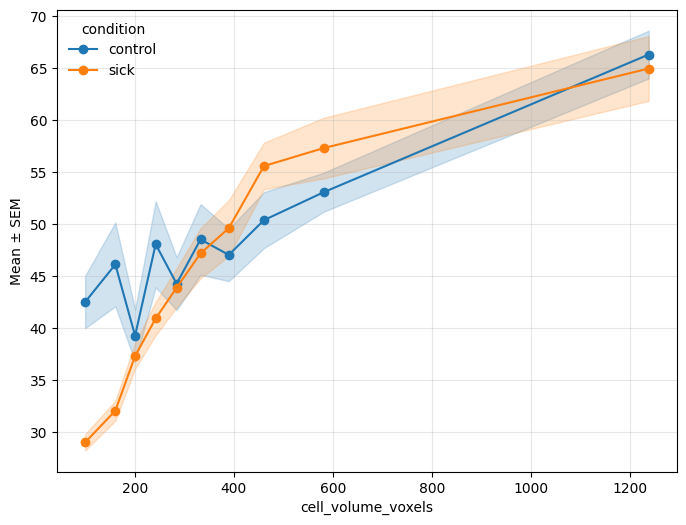

In [40]:
reload(vis_module)

fig, ax, summary_df = vis.binned_summary_plot(df=filtered_cells, x="cell_volume_voxels", y="num_punctas",
                                          group="condition",
                                          bins="quantile", n_bins=10, share_bins=True,
                                          agg="mean", spread="sem", show_counts=False)
summary_df

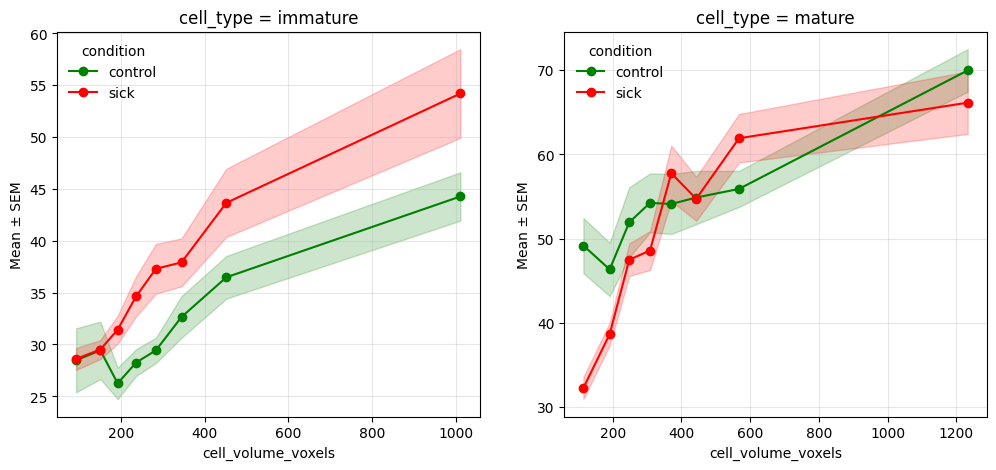

In [41]:

fig, ax, summary_df = vis.binned_summary_plot(df=filtered_cells, x="cell_volume_voxels", y="num_punctas",
                                          group="condition", facet="cell_type",
                                          bins="quantile", n_bins=8, share_bins=True, colors=custom_palette,
                                          agg="mean", spread="sem", figsize=(12,5), show_counts=False)


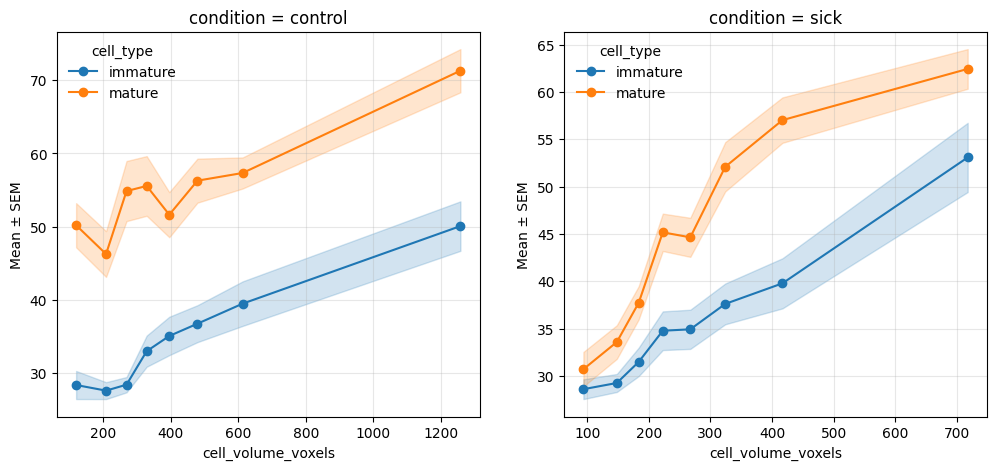

In [42]:

fig, ax, summary_df = vis.binned_summary_plot(df=filtered_cells, x="cell_volume_voxels", y="num_punctas",
                                          group="cell_type", facet="condition",
                                          bins="quantile", n_bins=8, share_bins=True, 
                                          agg="mean", spread="sem", figsize=(12,5), show_counts=False)


## Significance tests 

#### pre processing

In [43]:
filtered_cells['semi_radius'] = filtered_cells['cell_volume_voxels']**(1/3)
filtered_cells['log_voxel_volume'] = np.log10(filtered_cells['cell_volume_voxels'])
filtered_cells['log_convex_volume'] = np.log10(filtered_cells['convex_volume'])
filtered_cells['log_convex_area'] = np.log10(filtered_cells['convex_area'])
filtered_cells['log_num_punctas'] = np.log10(filtered_cells['num_punctas'])
filtered_cells['log_density'] = np.log10(filtered_cells['density'])


In [44]:
cell_features = ['semi_radius', 'log_voxel_volume', 'log_convex_volume', 
       'log_convex_area',
       'log_num_punctas', 'log_density',
       'compactness']
filtered_cells.columns

Index(['cell_id', 'num_punctas', 'X_centroid', 'Y_centroid', 'Z_centroid',
       'cell_volume_voxels', 'voxel_centroid_x', 'voxel_centroid_y',
       'voxel_centroid_z', 'Z_span', 'convex_volume', 'convex_area', 'density',
       'compactness', 'cell_type', 'sample', 'condition', 'STXBP1 expression',
       'semi_radius', 'log_voxel_volume', 'log_convex_volume',
       'log_convex_area', 'log_num_punctas', 'log_density'],
      dtype='object')

In [45]:
from scipy.stats import ttest_ind

def permutation_test_mean(df, value_col, group_col, group1, group2, stat='mean', n_permutations=10000, seed=None, perform_ttest=False):
    """
    Two-sided permutation test for difference in means between two groups.
    Optionally performs t-test as well.

    Returns:
        observed_diff: float
        p_value: float (permutation test)
        diffs: array of permuted differences
        (optional) t_stat, t_p: t-test statistic and p-value
    """
    if seed is not None:
        np.random.seed(seed)

    # ערכים מקוריים
    group1_vals = df[df[group_col] == group1][value_col].dropna().values
    group2_vals = df[df[group_col] == group2][value_col].dropna().values

    if stat == 'median':
        observed_diff = np.median(group1_vals) - np.median(group2_vals)
    else:
        observed_diff = np.mean(group1_vals) - np.mean(group2_vals)

    # כל הנתונים יחד
    all_vals = np.concatenate([group1_vals, group2_vals])
    n1 = len(group1_vals)

    # פרמוטציה
    diffs = []
    for _ in range(n_permutations):
        permuted = np.random.permutation(all_vals)
        if stat == 'median':
            diff = np.median(permuted[:n1]) - np.median(permuted[n1:])
        else:
            diff = np.mean(permuted[:n1]) - np.mean(permuted[n1:])
        diffs.append(diff)

    diffs = np.array(diffs)
    p_value = np.mean(np.abs(diffs) >= np.abs(observed_diff))

    if perform_ttest:
        t_stat, t_p = ttest_ind(group1_vals, group2_vals, equal_var=False)
        return observed_diff, p_value, diffs, t_stat, t_p

    return observed_diff, p_value, diffs


### grouped by condition - mean

In [46]:
results = []
for feature in cell_features:
    groupby = 'condition'
    group1 = 'sick'
    group2 ='control' 
    stat = 'mean'
    obs_diff, p, dist, t_stat, t_p = permutation_test_mean(
        df=filtered_cells,
        value_col=feature,
        group_col=groupby,
        group1=group1,
        group2=group2,
        stat=stat,
        seed=1,
        perform_ttest=True,
        n_permutations=10000
    )
    
    
    results.append({
        "feature": feature,
        "groupby": groupby,
        "group1": group1,
        "group2": group2,    
        "obs diff": obs_diff, 
        "p value (permutations)":p, 
        "permutation diffs": dist, 
        "t statistic": t_stat, 
        "p value (t-test)": t_p
    })
results_df = pd.DataFrame(results)
results_df.drop(columns='permutation diffs')

feature    groupby group1   group2  obs diff  \
0        semi_radius  condition   sick  control -0.850408   
1   log_voxel_volume  condition   sick  control -0.159378   
2  log_convex_volume  condition   sick  control -0.202888   
3    log_convex_area  condition   sick  control -0.136757   
4    log_num_punctas  condition   sick  control -0.049668   
5        log_density  condition   sick  control  0.109710   
6        compactness  condition   sick  control  0.081955   

   p value (permutations)  t statistic  p value (t-test)  
0                     0.0   -15.348675      2.253367e-50  
1                     0.0   -15.063810      1.483562e-48  
2                     0.0   -14.457363      4.914712e-45  
3                     0.0   -14.374745      1.439503e-44  
4                     0.0    -5.465019      5.195990e-08  
5                     0.0    10.215808      6.141835e-24  
6                     0.0    10.512473      3.981480e-25

In [47]:

formatted_df = results_df.drop(columns='permutation diffs').style.format(
    {
        "obs diff": f"{{:.{3}f}}",
        "p value (permutations)": f"{{:.{2}e}}", 
        "p value (t-test)": f"{{:.{2}e}}"
    }
)

formatted_df

### grouped by condition - median

In [48]:
results = []
for feature in cell_features:
    groupby = 'condition'
    group1 = 'sick'
    group2 ='control' 
    stat = 'median'
    obs_diff, p, dist, t_stat, t_p = permutation_test_mean(
        df=filtered_cells,
        value_col=feature,
        group_col=groupby,
        group1=group1,
        group2=group2,
        stat=stat,
        seed=1,
        perform_ttest=True,
        n_permutations=10000
    )
    
    
    results.append({
        "feature": feature,
        "groupby": groupby,
        "group1": group1,
        "group2": group2,    
        "obs diff": obs_diff, 
        "p value (permutations)":p, 
        "permutation diffs": dist, 
        "t statistic": t_stat, 
        "p value (t-test)": t_p
    })
results_df = pd.DataFrame(results)
results_df.drop(columns='permutation diffs')

feature    groupby group1   group2  obs diff  \
0        semi_radius  condition   sick  control -0.872397   
1   log_voxel_volume  condition   sick  control -0.170314   
2  log_convex_volume  condition   sick  control -0.211096   
3    log_convex_area  condition   sick  control -0.148520   
4    log_num_punctas  condition   sick  control -0.045757   
5        log_density  condition   sick  control  0.145877   
6        compactness  condition   sick  control  0.082514   

   p value (permutations)  t statistic  p value (t-test)  
0                  0.0000   -15.348675      2.253367e-50  
1                  0.0000   -15.063810      1.483562e-48  
2                  0.0000   -14.457363      4.914712e-45  
3                  0.0000   -14.374745      1.439503e-44  
4                  0.0103    -5.465019      5.195990e-08  
5                  0.0000    10.215808      6.141835e-24  
6                  0.0000    10.512473      3.981480e-25

### grouped by cell type - mean

In [49]:
results = []

for feature in cell_features:
    
    groupby = 'cell_type'
    group1 = 'mature'
    group2 ='immature' 
    stat = 'mean'
    obs_diff, p, dist, t_stat, t_p = permutation_test_mean(
        df=filtered_cells,
        value_col=feature,
        group_col=groupby,
        group1=group1,
        group2=group2,
        stat=stat,
        seed=1,
        perform_ttest=True,
        n_permutations=10000

    )
    
    results.append({
        "feature": feature,
        "groupby": groupby,
        "group1": group1,
        "group2": group2,    
        "obs diff": obs_diff, 
        "p value (permutations)":p, 
        "permutation diffs": dist, 
        "t statistic": t_stat, 
        "p value (t-test)": t_p
    })

results_df = pd.DataFrame(results)
results_df.drop(columns='permutation diffs')

feature    groupby  group1    group2  obs diff  \
0        semi_radius  cell_type  mature  immature  0.532930   
1   log_voxel_volume  cell_type  mature  immature  0.102338   
2  log_convex_volume  cell_type  mature  immature  0.131468   
3    log_convex_area  cell_type  mature  immature  0.089036   
4    log_num_punctas  cell_type  mature  immature  0.163260   
5        log_density  cell_type  mature  immature  0.060922   
6        compactness  cell_type  mature  immature -0.057026   

   p value (permutations)  t statistic  p value (t-test)  
0                     0.0     8.796244      3.886390e-18  
1                     0.0     8.849463      2.622119e-18  
2                     0.0     8.580529      2.511382e-17  
3                     0.0     8.585703      2.397825e-17  
4                     0.0    19.489777      6.097235e-77  
5                     0.0     5.263524      1.609417e-07  
6                     0.0    -6.798369      1.602820e-11

### grouped by cell type - median

In [50]:
results = []

for feature in cell_features:
    
    groupby = 'cell_type'
    group1 = 'mature'
    group2 ='immature' 
    stat = 'median'
    obs_diff, p, dist, t_stat, t_p = permutation_test_mean(
        df=filtered_cells,
        value_col=feature,
        group_col=groupby,
        group1=group1,
        group2=group2,
        stat=stat,
        seed=1,
        perform_ttest=True,
        n_permutations=10000

    )
    
    results.append({
        "feature": feature,
        "groupby": groupby,
        "group1": group1,
        "group2": group2,    
        "obs diff": obs_diff, 
        "p value (permutations)":p, 
        "permutation diffs": dist, 
        "t statistic": t_stat, 
        "p value (t-test)": t_p
    })

results_df = pd.DataFrame(results)
results_df.drop(columns='permutation diffs')

feature    groupby  group1    group2  obs diff  \
0        semi_radius  cell_type  mature  immature  0.586059   
1   log_voxel_volume  cell_type  mature  immature  0.114392   
2  log_convex_volume  cell_type  mature  immature  0.144360   
3    log_convex_area  cell_type  mature  immature  0.093291   
4    log_num_punctas  cell_type  mature  immature  0.190815   
5        log_density  cell_type  mature  immature  0.050705   
6        compactness  cell_type  mature  immature -0.067818   

   p value (permutations)  t statistic  p value (t-test)  
0                  0.0000     8.796244      3.886390e-18  
1                  0.0000     8.849463      2.622119e-18  
2                  0.0000     8.580529      2.511382e-17  
3                  0.0000     8.585703      2.397825e-17  
4                  0.0000    19.489777      6.097235e-77  
5                  0.0006     5.263524      1.609417e-07  
6                  0.0000    -6.798369      1.602820e-11

### Anova test

In [51]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'log_num_punctas ~ C(condition) * C(cell_type)'

model = ols(formula, data=filtered_cells).fit()

anova_table = sm.stats.anova_lm(model, typ=2)

print(formula)
print(anova_table)

log_num_punctas ~ C(condition) * C(cell_type)
                              sum_sq      df           F        PR(>F)
C(condition)                0.201515     1.0    5.075659  2.436811e-02
C(cell_type)               11.260449     1.0  283.622393  9.440452e-60
C(condition):C(cell_type)   0.259638     1.0    6.539641  1.062022e-02
Residual                   82.382180  2075.0         NaN           NaN


In [52]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'log_density ~ C(condition) * C(cell_type)'

model = ols(formula, data=filtered_cells).fit()

anova_table = sm.stats.anova_lm(model, typ=2)

print(formula)
print(anova_table)

log_density ~ C(condition) * C(cell_type)
                               sum_sq      df           F        PR(>F)
C(condition)                 7.610759     1.0  119.884724  3.654101e-27
C(cell_type)                 3.286108     1.0   51.762793  8.709211e-13
C(condition):C(cell_type)    1.682339     1.0   26.500218  2.883672e-07
Residual                   131.729256  2075.0         NaN           NaN


In [53]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'compactness ~ C(condition) * C(cell_type)'

model = ols(formula, data=filtered_cells).fit()

anova_table = sm.stats.anova_lm(model, typ=2)

print(formula)
print(anova_table)

compactness ~ C(condition) * C(cell_type)
                              sum_sq      df          F        PR(>F)
C(condition)                2.660137     1.0  89.268568  8.951853e-21
C(cell_type)                0.791594     1.0  26.564231  2.790855e-07
C(condition):C(cell_type)   0.403112     1.0  13.527581  2.410646e-04
Residual                   61.833448  2075.0        NaN           NaN


In [54]:
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
import pandas as pd

maov = MANOVA.from_formula('compactness + log_convex_volume + log_density ~ C(condition)', data=filtered_cells)
print(maov.mv_test())

                     Multivariate linear model
                                                                    
--------------------------------------------------------------------
       Intercept         Value   Num DF   Den DF    F Value   Pr > F
--------------------------------------------------------------------
          Wilks' lambda   0.0021 3.0000 2075.0000 323849.9567 0.0000
         Pillai's trace   0.9979 3.0000 2075.0000 323849.9567 0.0000
 Hotelling-Lawley trace 468.2168 3.0000 2075.0000 323849.9567 0.0000
    Roy's greatest root 468.2168 3.0000 2075.0000 323849.9567 0.0000
--------------------------------------------------------------------
                                                                    
---------------------------------------------------------------------
        C(condition)       Value   Num DF    Den DF   F Value  Pr > F
---------------------------------------------------------------------
            Wilks' lambda  0.9031  3.0000  2075.0000 

### deepen over compactness

In [55]:
immature_cells_df = filtered_cells[filtered_cells['cell_type'] == 'immature']
results = []

for feature in cell_features:
    
    groupby = 'condition'
    group1 = 'sick'
    group2 ='control' 
    stat = 'mean'
    obs_diff, p, dist, t_stat, t_p = permutation_test_mean(
        df=immature_cells_df,
        value_col=feature,
        group_col=groupby,
        group1=group1,
        group2=group2,
        stat=stat,
        seed=1,
        perform_ttest=True,
        n_permutations=10000

    )
    
    results.append({
        "feature": feature,
        "groupby": groupby,
        "group1": group1,
        "group2": group2,    
        "obs diff": obs_diff, 
        "p value (permutations)":p, 
        "permutation diffs": dist, 
        "t statistic": t_stat, 
        "p value (t-test)": t_p
    })

results_df = pd.DataFrame(results)
results_df.drop(columns='permutation diffs')

feature    groupby group1   group2  obs diff  \
0        semi_radius  condition   sick  control -0.985733   
1   log_voxel_volume  condition   sick  control -0.194194   
2  log_convex_volume  condition   sick  control -0.252087   
3    log_convex_area  condition   sick  control -0.169970   
4    log_num_punctas  condition   sick  control  0.010805   
5        log_density  condition   sick  control  0.204999   
6        compactness  condition   sick  control  0.113112   

   p value (permutations)  t statistic  p value (t-test)  
0                  0.0000   -10.859517      2.962808e-25  
1                  0.0000   -11.094620      2.461242e-26  
2                  0.0000   -10.795271      3.953469e-25  
3                  0.0000   -10.760991      5.467550e-25  
4                  0.3675     0.893511      3.719085e-01  
5                  0.0000    12.551673      1.500576e-32  
6                  0.0000     8.495550      1.253643e-16

In [56]:
mature_cells_df = filtered_cells[filtered_cells['cell_type'] == 'mature']
results = []

for feature in cell_features:
    
    groupby = 'condition'
    group1 = 'sick'
    group2 ='control' 
    stat = 'mean'
    obs_diff, p, dist, t_stat, t_p = permutation_test_mean(
        df=mature_cells_df,
        value_col=feature,
        group_col=groupby,
        group1=group1,
        group2=group2,
        stat=stat,
        seed=1,
        perform_ttest=True,
        n_permutations=10000

    )
    
    results.append({
        "feature": feature,
        "groupby": groupby,
        "group1": group1,
        "group2": group2,    
        "obs diff": obs_diff, 
        "p value (permutations)":p, 
        "permutation diffs": dist, 
        "t statistic": t_stat, 
        "p value (t-test)": t_p
    })

results_df = pd.DataFrame(results)
results_df.drop(columns='permutation diffs')

feature    groupby group1   group2  obs diff  \
0        semi_radius  condition   sick  control -0.668430   
1   log_voxel_volume  condition   sick  control -0.119336   
2  log_convex_volume  condition   sick  control -0.148872   
3    log_convex_area  condition   sick  control -0.100196   
4    log_num_punctas  condition   sick  control -0.037631   
5        log_density  condition   sick  control  0.081704   
6        compactness  condition   sick  control  0.052759   

   p value (permutations)  t statistic  p value (t-test)  
0                  0.0000    -9.592893      5.002736e-21  
1                  0.0000    -9.077940      5.105524e-19  
2                  0.0000    -8.562033      3.787660e-17  
3                  0.0000    -8.483339      7.167182e-17  
4                  0.0022    -3.316743      9.385016e-04  
5                  0.0000     6.092941      1.454946e-09  
6                  0.0000     5.484358      5.281930e-08

In [57]:
big_compactness_cells_df = filtered_cells.copy()
compactness_median = compactness_summary_df.loc[4, 'x_left']
big_compactness_cells_df = big_compactness_cells_df[big_compactness_cells_df['compactness'] >= compactness_median]

results = []

for feature in cell_features:
    
    groupby = 'condition'
    group1 = 'sick'
    group2 ='control' 
    stat = 'mean'
    obs_diff, p, dist, t_stat, t_p = permutation_test_mean(
        df=big_compactness_cells_df,
        value_col=feature,
        group_col=groupby,
        group1=group1,
        group2=group2,
        stat=stat,
        seed=1,
        perform_ttest=True,
        n_permutations=10000

    )
    
    results.append({
        "feature": feature,
        "groupby": groupby,
        "group1": group1,
        "group2": group2,    
        "obs diff": obs_diff, 
        "p value (permutations)":p, 
        "permutation diffs": dist, 
        "t statistic": t_stat, 
        "p value (t-test)": t_p
    })

results_df = pd.DataFrame(results)
results_df.drop(columns='permutation diffs')

feature    groupby group1   group2  obs diff  \
0        semi_radius  condition   sick  control -0.540750   
1   log_voxel_volume  condition   sick  control -0.114530   
2  log_convex_volume  condition   sick  control -0.129122   
3    log_convex_area  condition   sick  control -0.086194   
4    log_num_punctas  condition   sick  control -0.062571   
5        log_density  condition   sick  control  0.051958   
6        compactness  condition   sick  control  0.034751   

   p value (permutations)  t statistic  p value (t-test)  
0                  0.0000   -10.457533      2.648745e-24  
1                  0.0000   -10.120962      5.862828e-23  
2                  0.0000    -9.632435      4.812883e-21  
3                  0.0000    -9.538985      1.101408e-20  
4                  0.0000    -5.249833      1.894851e-07  
5                  0.0005     3.549731      4.065776e-04  
6                  0.0000     5.070043      4.778250e-07

In [58]:
results = []
small_compactness_cells_df = filtered_cells.copy()
small_compactness_cells_df = small_compactness_cells_df[small_compactness_cells_df['compactness'] <= compactness_median]

for feature in cell_features:
    
    groupby = 'condition'
    group1 = 'sick'
    group2 ='control' 
    stat = 'mean'
    obs_diff, p, dist, t_stat, t_p = permutation_test_mean(
        df=small_compactness_cells_df,
        value_col=feature,
        group_col=groupby,
        group1=group1,
        group2=group2,
        stat=stat,
        seed=1,
        perform_ttest=True,
        n_permutations=10000

    )
    
    results.append({
        "feature": feature,
        "groupby": groupby,
        "group1": group1,
        "group2": group2,    
        "obs diff": obs_diff, 
        "p value (permutations)":p, 
        "permutation diffs": dist, 
        "t statistic": t_stat, 
        "p value (t-test)": t_p
    })

results_df = pd.DataFrame(results)
results_df.drop(columns='permutation diffs')

feature    groupby group1   group2  obs diff  \
0        semi_radius  condition   sick  control -0.635495   
1   log_voxel_volume  condition   sick  control -0.103812   
2  log_convex_volume  condition   sick  control -0.127516   
3    log_convex_area  condition   sick  control -0.085597   
4    log_num_punctas  condition   sick  control  0.000792   
5        log_density  condition   sick  control  0.104603   
6        compactness  condition   sick  control  0.035657   

   p value (permutations)  t statistic  p value (t-test)  
0                  0.0000    -9.380650      4.864043e-20  
1                  0.0000    -8.915847      2.812889e-18  
2                  0.0000    -9.095225      5.997172e-19  
3                  0.0000    -9.082864      6.574083e-19  
4                  0.9549     0.061612      9.508855e-01  
5                  0.0000     7.398118      3.082651e-13  
6                  0.0000     6.275519      5.555853e-10

In [ ]:
puncta_significance = []
quantile_results = []
for quantile in range(0,8):
    
    results = []
    quan_compactness_cells_df = filtered_cells.copy()
    lower = compactness_summary_df.loc[quantile, 'x_left']
    quan_compactness_cells_df = quan_compactness_cells_df[quan_compactness_cells_df['compactness'] >= lower]
    upper = compactness_summary_df.loc[quantile, 'x_right']
    quan_compactness_cells_df = quan_compactness_cells_df[quan_compactness_cells_df['compactness'] <= upper]
    
    for feature in cell_features:
        
        groupby = 'condition'
        group1 = 'sick'
        group2 ='control' 
        stat = 'mean'
        obs_diff, p, dist, t_stat, t_p = permutation_test_mean(
            df=quan_compactness_cells_df,
            value_col=feature,
            group_col=groupby,
            group1=group1,
            group2=group2,
            stat=stat,
            seed=1,
            perform_ttest=True,
            n_permutations=10000
    
        )
        
        results.append({
            "feature": feature,
            "groupby": groupby,
            "group1": group1,
            "group2": group2,    
            "obs diff": obs_diff, 
            "p value (permutations)":p, 
            "permutation diffs": dist, 
            "t statistic": t_stat, 
            "p value (t-test)": t_p
        })

        if feature == 'log_num_punctas':
            puncta_significance.append(p)
    
    results_df = pd.DataFrame(results)
    quantile_results.append(results_df)
    print("quantile:", quantile)
    print(results_df[['feature', 'p value (permutations)', 'p value (t-test)']])

In [82]:
# correction for puncta_significance
puncta_significance[0] = 1
from statsmodels.sandbox.stats.multicomp import multipletests
puncta_significance_adj = multipletests(puncta_significance, method='fdr_bh')[1]
print(puncta_significance_adj)

[1.         1.         0.66946667 0.66946667 0.0672     0.0044
 0.01813333 0.0044    ]


Asterisks plotted for 3 specified bins.


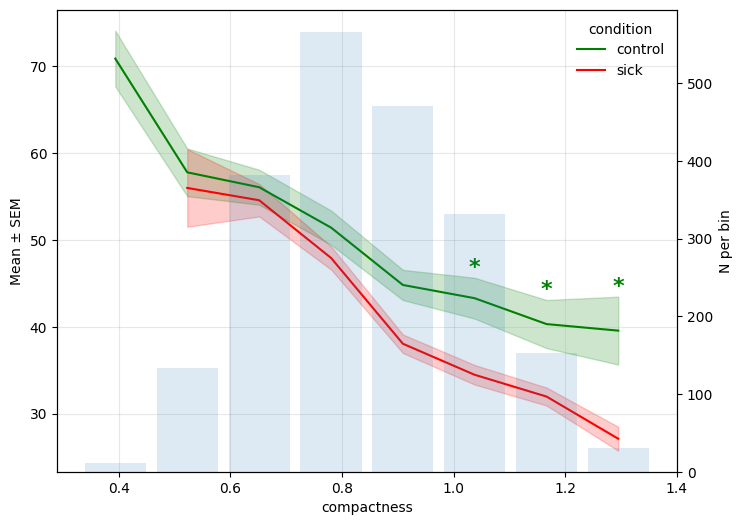

In [93]:
reload(vis_module)

fig, ax, summary_df = vis.binned_summary_plot(df=filtered_cells, x="compactness", y="num_punctas",
                                          group="condition", 
                                          bins="uniform", n_bins=8, share_bins=True, colors=custom_palette,
                                          agg="mean", spread="sem")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. DEFINE YOUR SIGNIFICANT BIN INDICES AND CONSTANTS ---

# REPLACE THIS LIST with the actual 0-indexed integer list of bins where the difference is significant.
# Example: [0, 2, 5] refers to the 1st, 3rd, and 6th bins from the left.
significant_bin_indices = [5,6,7]

Y_POSITION_OFFSET_FACTOR = 0.0 # 3% offset above the highest error band

# --- 2. DATA PREPARATION ---
# NOTE: Assume 'fig', 'ax', and 'summary_df' are already loaded from binned_summary_plot output.

# Calculate 'x_center' on the summary table (needed for the actual plotting position)
summary_df['x_center'] = 0.5 * (summary_df['x_left'] + summary_df['x_right'])

# Calculate the maximum y-height for ALL unique bins.
# This results in a new DataFrame that is implicitly ordered by 'x_center' (Bin Index 0, 1, 2, ...).
max_y_per_bin = summary_df.groupby('x_center')['y_spread_high'].max().reset_index()
max_y_per_bin.rename(columns={'y_spread_high': 'max_y_spread_high'}, inplace=True)

# --- 3. PLOTTING LOGIC ---

if not significant_bin_indices:
    print("No bin indices were provided for marking.")
else:
    # Use positional indexing (.iloc) to filter the rows corresponding to the user's indices.
    # This directly selects the data (x_center and max_y_high) for the significant bins.
    significant_bins_data = max_y_per_bin.iloc[significant_bin_indices]

    # Iterate through the significant bins data and plot the markers
    for index, row in significant_bins_data.iterrows():
        x_pos = row['x_center']
        max_y_high = row['max_y_spread_high']
        
        # Calculate the Y position (slightly above the highest error bar)
        y_star_position = max_y_high # * (1 + Y_POSITION_OFFSET_FACTOR)
        
        # Add the asterisk to the graph's main axis
        ax.text(
            x=x_pos, 
            y=y_star_position, 
            s='*', # Asterisk symbol
            ha='center', # Horizontal alignment: Center
            va='bottom', # Vertical alignment: Bottom of the character
            fontsize=16, 
            color='green', 
            weight='bold',
            zorder=10 # Ensure the asterisk is rendered on top
        )

    print(f"Asterisks plotted for {len(significant_bins_data)} specified bins.")
    
fig.savefig(os.path.join(figures_path, "num_punctas_by_compactness.png")) 

In [76]:
significant_results

feature    groupby group1   group2  obs diff  \
4  log_num_punctas  condition   sick  control -0.162024   

   p value (permutations)                                  permutation diffs  \
4                  0.0011  [0.0158930012033347, 0.025855486477593503, -0....   

   t statistic  p value (t-test)  
4    -3.202475          0.008151

In [89]:
summary_df

facet    group  bin_idx  x_left  x_right  x_center    n     y_mean  \
0   None  control        0   0.329    0.458    0.3935   11  70.909091   
1   None  control        1   0.458    0.587    0.5225  110  57.800000   
2   None  control        2   0.587    0.716    0.6515  263  56.079848   
3   None  control        3   0.716    0.845    0.7805  346  51.419075   
4   None  control        4   0.845    0.973    0.9090  271  44.819188   
5   None  control        5   0.973    1.102    1.0375  166  43.295181   
6   None  control        6   1.102    1.231    1.1665   58  40.310345   
7   None  control        7   1.231    1.359    1.2950    9  39.555556   
8   None     sick        0   0.329    0.458    0.3935    0        NaN   
9   None     sick        1   0.458    0.587    0.5225   24  56.000000   
10  None     sick        2   0.587    0.716    0.6515  119  54.579832   
11  None     sick        3   0.716    0.845    0.7805  220  47.918182   
12  None     sick        4   0.845    0.973    0.9090  200  38.045000   
13  None     sick        5   0.973    1.102    1.0375  166  34.469880   
14  None     sick        6   1.102    1.231    1.1665   95  31.957895   
15  None     sick        7   1.231    1.359    1.2950   21  27.095238   

     y_variance      y_agg  y_spread_low  y_spread_high  
0    113.290909  70.909091     67.699858      74.118323  
1    830.234862  57.800000     55.052712      60.547288  
2   1070.096653  56.079848     54.062719      58.096977  
3   1346.568795  51.419075     49.446306      53.391844  
4    822.230149  44.819188     43.077333      46.561043  
5    918.948704  43.295181     40.942345      45.648016  
6    447.094979  40.310345     37.533920      43.086770  
7    137.777778  39.555556     35.642930      43.468182  
8           NaN        NaN           NaN            NaN  
9    480.000000  56.000000     51.527864      60.472136  
10   414.974505  54.579832     52.712432      56.447231  
11   389.874554  47.918182     46.586958      49.249406  
12   227.902487  38.045000     36.977521      39.112479  
13   211.729390  34.469880     33.340509      35.599250  
14   102.402464  31.957895     30.919665      32.996124  
15    39.990476  27.095238     25.715271      28.475205

## Plot one cell

In [60]:
organoids_data.samples['002CTR_D5_twins_right'].plot_cell_with_puncta('3165')
organoids_data.samples['002CTR_D5_twins_right'].cells[organoids_data.samples['002CTR_D5_twins_right'].cells['cell_id'] == '3165']


cell_id  num_punctas  X_centroid  Y_centroid  Z_centroid  \
1536    3165           33    8.220962   17.227684   19.536811   

      cell_volume_voxels  voxel_centroid_x  voxel_centroid_y  \
1536         1815.547384         27.040159         60.275137   

      voxel_centroid_z     Z_span  convex_volume  convex_area   density  \
1536         65.345916  20.363636    3904.912753  1373.646951  0.018176   

      compactness cell_type  
1536     0.464939    mature

In [61]:
stx_a1_path = r"C:\Users\Moshe\OneDrive\coding\SpatialGenomicsLab\SegmentedData\Organoids\filtered_organoids\001STXBP1_A1"
stx_a1_data = pd.read_csv(os.path.join(stx_a1_path, "RNA_with_cells.csv"))
stx_a1_data['cell_id'] = [cid.split('_')[0] for cid in stx_a1_data['cell_id']]
stx_a1_data.to_csv(os.path.join(stx_a1_path, "RNA_with_cells.csv"))
stx_a1 = SampleObject.from_files(sample_folder=stx_a1_path, xy_scaling=1/3.3, z_scaling=1/3.3)

AttributeError: 'int' object has no attribute 'split'

In [ ]:
filtered_cells['sample'].unique()

In [ ]:
# example = filtered_cells[filtered_cells['sample'] == '002CTR_D5_twins_right']
example = stx_a1.cells
example = example[example['num_punctas'] >= 10]
example = example[example['Z_span'] >= 3]


In [ ]:
(example['X_centroid'] - example['voxel_centroid_x']).mean()

In [ ]:
(example['Y_centroid'] - example['voxel_centroid_y']).mean()

In [ ]:
(example['Z_centroid'] - example['voxel_centroid_z']).mean()

In [ ]:
(example['X_centroid'] - example['voxel_centroid_x']).std()

In [ ]:
(example['Z_centroid'].max() - example['Z_centroid'].min())

In [ ]:
(example['voxel_centroid_z'].max() - example['voxel_centroid_z'].min())

In [ ]:
example.cell_id.values

In [ ]:
stx_a1.plot_cell_with_puncta(example.cell_id.values[5])
